# Subspace-constrained Reconstruction for T1 Mapping in BART

This tutorial uses the BART command-line inteface (CLI) (http://mrirecon.github.io/bart/) and presents how to use BART for T1 Mapping using subspace-constrained reconstruction.

First we need to define a helper function to visualize our data arrays.

Author: Xiaoqing Wang (xiaoqing.wang@med.uni-goettingen.de)

In [25]:
echo "BART version"
bart version

# BASH function to write BART file to png,
# display the png, and then remove it
function imshow () {
    bart toimg -W $1 $1.png > /dev/null
    cat $1.png | display
}
export -f imshow

# BASH function to visualize timesteps of BART cfl file
function show_timesteps () {

    data=$1
    shift
    pos=("$@")

    ind=0

    for t in "${pos[@]}"
    do
       bart slice 5 $t $data _slice$ind
       ind=$((ind+1))
    done

    bart join 6 `seq -f "_slice%g" 0 $((ind-1))` _slices
    
    DIM=`bart show -d 0 _slices`

    bart reshape $(bart bitmask 1 6) $((DIM*ind)) 1 {_,}slices

    imshow slices
}
export -f show_timesteps

BART version
v0.7.00


### 1. Simulations

### 1.1 Simulate the IR radial FLASH raw data using the phantom tool in BART

Similar to the previous example,  we can create a numerical phantom with the inversion-recovery radial FLASH acquisition

In [4]:
TR=0.0041
DIM=384
SPOKES=1
REP=1020
NC=8
NBR=$((DIM/2))

# create trajectory
bart traj -x $DIM -y $SPOKES -t $REP -c -r -G _traj
bart transpose 5 10 {_,}traj
bart scale 0.5 traj traj1

# create geometry basis functions
bart phantom -s$NC -T -k -b -t traj1 _basis_geom

# create simulation basis functions
bart signal -F -I -n$REP -r$TR  -1 3:3:1 -2 1:1:1 _basis_simu_water
bart signal -F -I -n$REP -r$TR  -1 0.2:2.2:10 -2 0.045:0.045:1 _basis_simu_tubes

bart scale 1. _basis_simu_tubes _basis_simu_sdim_tubes
bart join 6 _basis_simu{_water,_sdim_tubes,}

# create simulated dataset
bart fmac -s $(bart bitmask 6) _basis_geom _basis_simu phantom_ksp
bart phantom -x$NBR -T mask

In [5]:
# add noise to the simulated dataset 
bart noise -n500 phantom_ksp phantom_ksp_noisy

In [6]:
# create the reference T1 (noiseless) 
bart index 6 10 tmp_T1s
bart scale 0.2 tmp_T1s tmp_T1s_1
bart ones 7 1 1 1 1 1 1 10 tmp_ones_T1s
bart saxpy 0.2 tmp_ones_T1s tmp_T1s_1 tmp_T1s_2
bart ones 7 1 1 1 1 1 1 1 tmp_ones_T1s_1
bart scale 3.0 tmp_ones_T1s_1 tmp_ones_T1s_2
bart join 6 tmp_ones_T1s_2 tmp_T1s_2 ref_T1s
bart phantom -T -b -x$NBR phan_T1
bart fmac -s $(bart bitmask 6) phan_T1 ref_T1s phan_ref_T1s
bart invert phan_ref_T1s phan_ref_R1s

#### 1.2 Coil sensitivity estimation (by NLINV) using steady-state data

In [7]:
bart extract 5 $((REP-400)) $REP traj traj_state
bart extract 5 $((REP-400)) $REP phantom_ksp_noisy phantom_ksp_state
bart transpose 2 5 traj_state traj_state1
bart transpose 2 5 phantom_ksp_state phantom_ksp_state1

ITER=8
DEBUG=3
bart nlinv -d$DEBUG -i$ITER -a1000 -t traj_state1 phantom_ksp_state1 reco sens_nlinv
bart resize -c 0 $DIM 1 $DIM sens_nlinv sens_nlinv1
bart scale 100. sens_nlinv1 sens

Est. image size: 384 384 1
Allocating 153600 (vs. 743424) + 589824
ksp : [  1 384 400   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [768 768   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 384 400   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
ksp : [  1 384 400   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [768 768   1   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 384 400   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
Scaling: 0.000025


### 1.3 Linear subspace reconstruction

### 1.3.1  Reshape data and prepare time vector

In [8]:
# data binning
nspokes_per_frame=10
bart reshape $(bart bitmask 4 5) $nspokes_per_frame $((REP/nspokes_per_frame)) traj traj1
bart transpose 4 2 traj1 traj

bart reshape $(bart bitmask 4 5) $nspokes_per_frame $((REP/nspokes_per_frame)) phantom_ksp_noisy phantom_ksp_2
bart transpose 4 2 phantom_ksp_2 phantom_ksp

# time vector
TR1=4100
bart index 5 $((REP/nspokes_per_frame)) tmp1
bart scale $(($nspokes_per_frame * $TR1)) tmp1 tmp2
bart ones 6 1 1 1 1 1 $((REP/nspokes_per_frame)) tmp1
bart saxpy $((($nspokes_per_frame / 2) * $TR1)) tmp1 tmp2 tmp3
bart scale 0.000001 tmp3 TI

### 1.3.2 Generate the dictionary, perform SVD and create the orthogonal temporal basis

In [9]:
# Generate the dictionary, perform SVD and
nR1s=1000
nMss=100
TR2=0.041
bart signal -F -I -1 5e-3:5:$nR1s -3 1e-2:1:$nMss -r$TR2 -n$((REP/nspokes_per_frame)) dicc

bart reshape $(bart bitmask 6 7) $((nR1s * nMss)) 1 dicc dicc1
bart squeeze dicc1 dicc2
bart svd -e dicc2 U S V

In [10]:
# create the orthogonal temporal basis
nCoe=4 # use 4 coefficient maps
bart extract 1 0 $nCoe U basis
bart transpose 1 6 basis basis1
bart transpose 0 5 basis1 basis_${nCoe}

### 1.3.3 Perform subspace-constrained reconstruction with joint l1-Wavelet constraints on the coefficient maps

In [11]:
ITER=100
REG=0.0005

bart pics -SeH -d5 -RW:$(bart bitmask 0 1):$(bart bitmask 6):$REG -i$ITER -t traj -B basis_${nCoe} phantom_ksp sens subspace_reco
bart resize -c 0 $NBR 1 $NBR subspace_reco tmp
bart fmac mask tmp tmp_masked

Basis: [384 384   1   8   1 102   4   1   1   1   1   1   1   1   1   1 ]
Max:   [384 384   1   8   1   1   4   1   1   1   1   1   1   1   1   1 ]
Hogwild stepsize
[  1 384  10   8   1 102   4   1   1   1   1   1   1   1   1   1 ]
[384 384   1   8   1   1   4   1   1   1   1   1   1   1   1   1 ]
ksp : [  1 384  10   8   1 102   4   1   1   1   1   1   1   1   1   1 ]
cim : [384 384   1   8   1   1   4   1   1   1   1   1   1   1   1   1 ]
traj: [  3 384  10   1   1 102   1   1   1   1   1   1   1   1   1   1 ]
wgh : [  1 384  10   1   1 102   1   1   1   1   1   1   1   1   1   1 ]
bas : [  1   1   1   1   1 102   4   1   1   1   1   1   1   1   1   1 ]
NUFFT: Toeplitz mode
psf_dims: [384 384   1   1   1 102   1   1   1   1   1   1   1   1   1   1 ]
nufft kernel dims: [  1 384  10   1   1   4   4   1   1   1   1   1   1   1   1   1   1 102 ]
nufft psf dims:    [768 768   1   1   1   4   4   1   1   1   1   1   1   1   1   1   1   1 ]
nufft traj dims:   [  3 384  10   1   1   1   1   

In [12]:
bart reshape $(bart bitmask 1 6) $((NBR*nCoe)) 1 tmp_masked subspace_maps

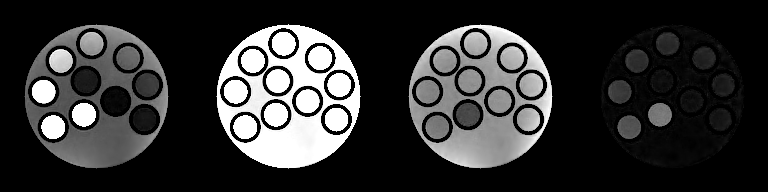

In [13]:
imshow subspace_maps

### 1.3.4 Project the reconstructed coefficient maps to images and perform pixel-wise fitting to obtain T1 map

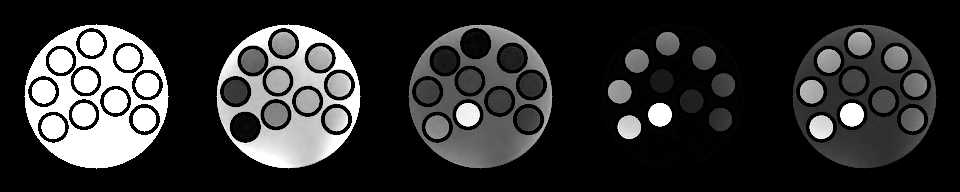

In [26]:
bart fmac -s $(bart bitmask 6) basis_${nCoe} tmp_masked imgs
t=( 0, 5, 10, 20, 100 )

show_timesteps imgs "${t[@]}"

In [ ]:
python3 mapping_piecewise.py imgs T1 TI maps

bart extract 2 0 3 maps tmp1
bart transpose 2 6 tmp1 tmp2

bart looklocker -t0.0 -D0.0 tmp2 tmp3
bart scale 0.5 tmp3 T1map
bart fmac mask T1map subspace_T1map 

### 1.3.5 Calculate the T1 difference and display

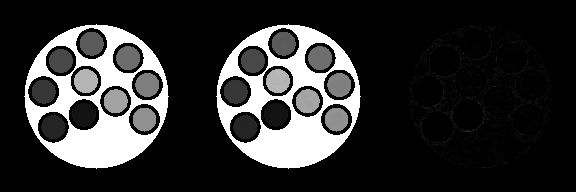

In [15]:
bart saxpy -- -1.0 subspace_T1map phan_ref_T1s subspace_diff_T1map
bart join 1 phan_ref_T1s subspace_T1map subspace_diff_T1map subspace_comparison
imshow subspace_comparison
python3 save_maps.py subspace_comparison viridis 0 2.0 subspace_comparison.png

### 2. In-vivo brain data

### 2.1 Load data

In [16]:
wget -q https://zenodo.org/record/4060287/files/IR-FLASH.cfl
wget -q https://zenodo.org/record/4060287/files/IR-FLASH.hdr

In [27]:
bart show -m IR-FLASH
READ=`bart show -d 0 IR-FLASH`
SPOKES=`bart show -d 2 IR-FLASH`
COILS=`bart show -d 3 IR-FLASH`
TIME=`bart show -d 10 IR-FLASH`
NBR2=$((READ/2))

Type: complex float
Dimensions: 16
AoD:	512	1	1	16	1	1	1	1	1	1	1020	1	1	1	1	1


### 2.2 Linear subspace reconstruction

### 2.2.1 Generation of golden-angle-based radial trajectory, gradient delays and data compression

In [28]:
GA=7
bart traj -r -c -D -G -x$READ -y1 -s$GA -t$((SPOKES*TIME)) traj

#reshape data
bart transpose 0 1 IR-FLASH ksp

# use steady-state data to do gradient-delay correction
nstate=100

bart extract 10 $((SPOKES*TIME-nstate)) $((SPOKES*TIME)) traj traj_extract
bart extract 10 $((SPOKES*TIME-nstate)) $((SPOKES*TIME)) ksp ksp_extract

bart transpose 10 2 traj_extract traj_extract1
bart transpose 10 2 ksp_extract ksp_extract1

bart traj -D -r -c -G -x$READ -y1 -s$GA -t$((SPOKES*TIME)) -q $(bart estdelay -R traj_extract1 ksp_extract1) trajn

# data compression
bart cc -A -p 8 ksp ksp_cc

Done.


### 2.2 Coil sensitivity estimation (by NLINV) using steady-state data

In [29]:
bart extract 10 $((SPOKES*TIME-300)) $((SPOKES*TIME)) trajn traj_state
bart extract 10 $((SPOKES*TIME-300)) $((SPOKES*TIME)) ksp_cc ksp_cc_state
bart transpose 2 10 traj_state traj_state1
bart transpose 2 10 ksp_cc_state ksp_cc_state1

ITER=12
DEBUG=4
bart nlinv -d$DEBUG -i$ITER -a1000 -t traj_state1 ksp_cc_state1 reco_nlinv sens_nlinv
bart resize -c 0 $READ 1 $READ sens_nlinv sens_nlinv1
bart scale 20. sens_nlinv1 sens

Est. image size: 512 514 1
nufft kernel dims: [  1 512 300   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
nufft psf dims:    [1024 1028   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
nufft traj dims:   [  3 512 300   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
Allocating 153600 (vs. 1206272) + 1052672
ksp : [  1 512 300   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [1024 1028   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 512 300   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
ksp : [  1 512 300   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [1024 1028   1   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 512 300   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
Scaling: 133.175537
Step: 0, Res: 99.999999
	 cg:   0
Step: 1, Res: 6663.066320
	 cg:   0
Step: 2, Res: 486.923166
	 cg:   0
Step: 3, Res: 486.302929
	 cg:   0
Step: 4, Res: 334.860683
	 cg:   0
Step: 5, R

### 2.3 Perform subspace-constrained reconstruction

In [30]:
bart reshape $(bart bitmask 2 5 10) $nspokes_per_frame $((SPOKES*TIME/nspokes_per_frame)) 1 trajn traj

bart reshape $(bart bitmask 4 5 10) $nspokes_per_frame $((SPOKES*TIME/nspokes_per_frame)) 1 ksp_cc ksp_cc1
bart transpose 4 2 ksp_cc1 ksp_cc2

ITER=100
REG=0.0015

bart pics -SeH -d5 -RW:$(bart bitmask 0 1):$(bart bitmask 6):$REG -i$ITER -t traj -B basis_${nCoe} ksp_cc2 sens subspace_reco
bart resize -c 0 $NBR2 1 $NBR2 subspace_reco coeff_maps

Basis: [512 512   1   8   1 102   4   1   1   1   1   1   1   1   1   1 ]
Max:   [512 512   1   8   1   1   4   1   1   1   1   1   1   1   1   1 ]
Hogwild stepsize
[  1 512  10   8   1 102   4   1   1   1   1   1   1   1   1   1 ]
[512 512   1   8   1   1   4   1   1   1   1   1   1   1   1   1 ]
ksp : [  1 512  10   8   1 102   4   1   1   1   1   1   1   1   1   1 ]
cim : [512 512   1   8   1   1   4   1   1   1   1   1   1   1   1   1 ]
traj: [  3 512  10   1   1 102   1   1   1   1   1   1   1   1   1   1 ]
wgh : [  1 512  10   1   1 102   1   1   1   1   1   1   1   1   1   1 ]
bas : [  1   1   1   1   1 102   4   1   1   1   1   1   1   1   1   1 ]
NUFFT: Toeplitz mode
psf_dims: [512 512   1   1   1 102   1   1   1   1   1   1   1   1   1   1 ]
nufft kernel dims: [  1 512  10   1   1   4   4   1   1   1   1   1   1   1   1   1   1 102 ]
nufft psf dims:    [1024 1024   1   1   1   4   4   1   1   1   1   1   1   1   1   1   1   1 ]
nufft traj dims:   [  3 512  10   1   1   1   1 

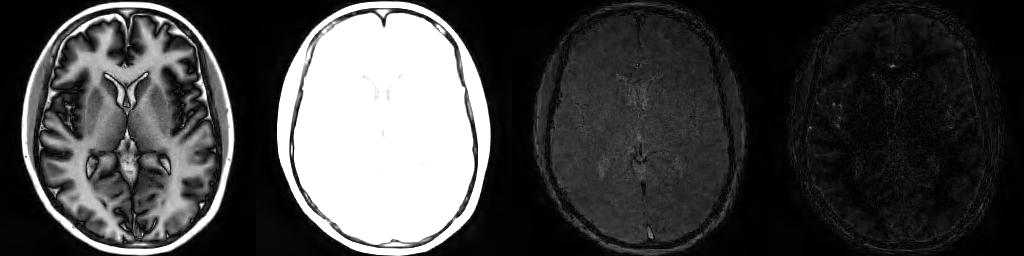

In [31]:
# Display all the coefficient maps
bart reshape $(bart bitmask 1 6) $((NBR2*nCoe)) 1 coeff_maps subspace_maps
bart flip $(bart bitmask 0) subspace_maps subspace_maps1
imshow subspace_maps1

### 2.4 Project the reconstructed coefficient maps to images and perform pixel-wise fitting to obtain T1 map

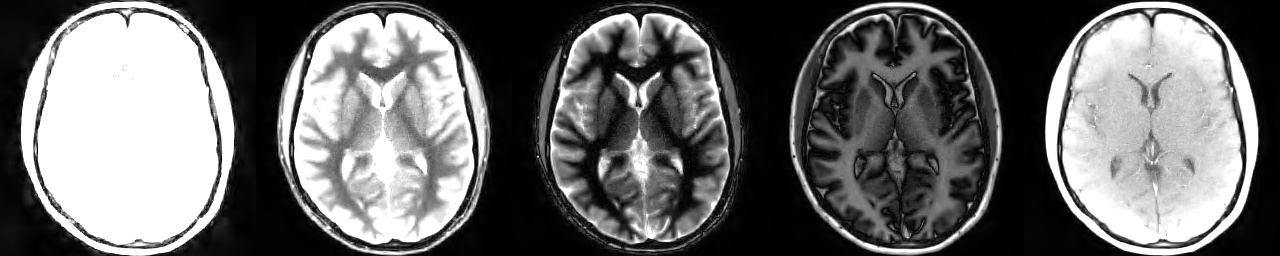

In [34]:
bart fmac -s $(bart bitmask 6) basis_${nCoe} coeff_maps imgs
bart flip $(bart bitmask 0) imgs imgs1
t=( 0, 5, 10, 20, 100 )

show_timesteps imgs1 "${t[@]}"

Pixel: (0, 0)
Pixel: (0, 1)
Pixel: (0, 2)
Pixel: (0, 3)
Pixel: (0, 4)
Pixel: (0, 5)
Pixel: (0, 6)
Pixel: (0, 7)
Pixel: (0, 8)
Pixel: (0, 9)
Pixel: (0, 10)
Pixel: (0, 11)
Pixel: (0, 12)
Pixel: (0, 13)
Pixel: (0, 14)
Pixel: (0, 15)
Pixel: (0, 16)
Pixel: (0, 17)
Pixel: (0, 18)
Pixel: (0, 19)
Pixel: (0, 20)
Pixel: (0, 21)
Pixel: (0, 22)
Pixel: (0, 23)
Pixel: (0, 24)
Pixel: (0, 25)
Pixel: (0, 26)
Pixel: (0, 27)
Pixel: (0, 28)
Pixel: (0, 29)
Pixel: (0, 30)
Pixel: (0, 31)
Pixel: (0, 32)
Pixel: (0, 33)
Pixel: (0, 34)
Pixel: (0, 35)
Pixel: (0, 36)
Pixel: (0, 37)
Pixel: (0, 38)
Pixel: (0, 39)
Pixel: (0, 40)
Pixel: (0, 41)
Pixel: (0, 42)
Pixel: (0, 43)
Pixel: (0, 44)
Pixel: (0, 45)
Pixel: (0, 46)
Pixel: (0, 47)
Pixel: (0, 48)
Pixel: (0, 49)
Pixel: (0, 50)
Pixel: (0, 51)
Pixel: (0, 52)
Pixel: (0, 53)
Pixel: (0, 54)
Pixel: (0, 55)
Pixel: (0, 56)
Pixel: (0, 57)
Pixel: (0, 58)
Pixel: (0, 59)
Pixel: (0, 60)
Pixel: (0, 61)
Pixel: (0, 62)
Pixel: (0, 63)
Pixel: (0, 64)
Pixel: (0, 65)
Pixel: (0, 66)
Pixel

Pixel: (2, 16)
Pixel: (2, 17)
Pixel: (2, 18)
Pixel: (2, 19)
Pixel: (2, 20)
Pixel: (2, 21)
Pixel: (2, 22)
Pixel: (2, 23)
Pixel: (2, 24)
Pixel: (2, 25)
Pixel: (2, 26)
Pixel: (2, 27)
Pixel: (2, 28)
Pixel: (2, 29)
Pixel: (2, 30)
Pixel: (2, 31)
Pixel: (2, 32)
Pixel: (2, 33)
Pixel: (2, 34)
Pixel: (2, 35)
Pixel: (2, 36)
Pixel: (2, 37)
Pixel: (2, 38)
Pixel: (2, 39)
Pixel: (2, 40)
Pixel: (2, 41)
Pixel: (2, 42)
Pixel: (2, 43)
Pixel: (2, 44)
Pixel: (2, 45)
Pixel: (2, 46)
Pixel: (2, 47)
Pixel: (2, 48)
Pixel: (2, 49)
Pixel: (2, 50)
Pixel: (2, 51)
Pixel: (2, 52)
Pixel: (2, 53)
Pixel: (2, 54)
Pixel: (2, 55)
Pixel: (2, 56)
Pixel: (2, 57)
Pixel: (2, 58)
Pixel: (2, 59)
Pixel: (2, 60)
Pixel: (2, 61)
Pixel: (2, 62)
Pixel: (2, 63)
Pixel: (2, 64)
Pixel: (2, 65)
Pixel: (2, 66)
Pixel: (2, 67)
Pixel: (2, 68)
Pixel: (2, 69)
Pixel: (2, 70)
Pixel: (2, 71)
Pixel: (2, 72)
Pixel: (2, 73)
Pixel: (2, 74)
Pixel: (2, 75)
Pixel: (2, 76)
Pixel: (2, 77)
Pixel: (2, 78)
Pixel: (2, 79)
Pixel: (2, 80)
Pixel: (2, 81)
Pixel: (2,

Pixel: (4, 31)
Pixel: (4, 32)
Pixel: (4, 33)
Pixel: (4, 34)
Pixel: (4, 35)
Pixel: (4, 36)
Pixel: (4, 37)
Pixel: (4, 38)
Pixel: (4, 39)
Pixel: (4, 40)
Pixel: (4, 41)
Pixel: (4, 42)
Pixel: (4, 43)
Pixel: (4, 44)
Pixel: (4, 45)
Pixel: (4, 46)
Pixel: (4, 47)
Pixel: (4, 48)
Pixel: (4, 49)
Pixel: (4, 50)
Pixel: (4, 51)
Pixel: (4, 52)
Pixel: (4, 53)
Pixel: (4, 54)
Pixel: (4, 55)
Pixel: (4, 56)
Pixel: (4, 57)
Pixel: (4, 58)
Pixel: (4, 59)
Pixel: (4, 60)
Pixel: (4, 61)
Pixel: (4, 62)
Pixel: (4, 63)
Pixel: (4, 64)
Pixel: (4, 65)
Pixel: (4, 66)
Pixel: (4, 67)
Pixel: (4, 68)
Pixel: (4, 69)
Pixel: (4, 70)
Pixel: (4, 71)
Pixel: (4, 72)
Pixel: (4, 73)
Pixel: (4, 74)
Pixel: (4, 75)
Pixel: (4, 76)
Pixel: (4, 77)
Pixel: (4, 78)
Pixel: (4, 79)
Pixel: (4, 80)
Pixel: (4, 81)
Pixel: (4, 82)
Pixel: (4, 83)
Pixel: (4, 84)
Pixel: (4, 85)
Pixel: (4, 86)
Pixel: (4, 87)
Pixel: (4, 88)
Pixel: (4, 89)
Pixel: (4, 90)
Pixel: (4, 91)
Pixel: (4, 92)
Pixel: (4, 93)
Pixel: (4, 94)
Pixel: (4, 95)
Pixel: (4, 96)
Pixel: (4,

Pixel: (6, 46)
Pixel: (6, 47)
Pixel: (6, 48)
Pixel: (6, 49)
Pixel: (6, 50)
Pixel: (6, 51)
Pixel: (6, 52)
Pixel: (6, 53)
Pixel: (6, 54)
Pixel: (6, 55)
Pixel: (6, 56)
Pixel: (6, 57)
Pixel: (6, 58)
Pixel: (6, 59)
Pixel: (6, 60)
Pixel: (6, 61)
Pixel: (6, 62)
Pixel: (6, 63)
Pixel: (6, 64)
Pixel: (6, 65)
Pixel: (6, 66)
Pixel: (6, 67)
Pixel: (6, 68)
Pixel: (6, 69)
Pixel: (6, 70)
Pixel: (6, 71)
Pixel: (6, 72)
Pixel: (6, 73)
Pixel: (6, 74)
Pixel: (6, 75)
Pixel: (6, 76)
Pixel: (6, 77)
Pixel: (6, 78)
Pixel: (6, 79)
Pixel: (6, 80)
Pixel: (6, 81)
Pixel: (6, 82)
Pixel: (6, 83)
Pixel: (6, 84)
Pixel: (6, 85)
Pixel: (6, 86)
Pixel: (6, 87)
Pixel: (6, 88)
Pixel: (6, 89)
Pixel: (6, 90)
Pixel: (6, 91)
Pixel: (6, 92)
Pixel: (6, 93)
Pixel: (6, 94)
Pixel: (6, 95)
Pixel: (6, 96)
Pixel: (6, 97)
Pixel: (6, 98)
Pixel: (6, 99)
Pixel: (6, 100)
Pixel: (6, 101)
Pixel: (6, 102)
Pixel: (6, 103)
Pixel: (6, 104)
Pixel: (6, 105)
Pixel: (6, 106)
Pixel: (6, 107)
Pixel: (6, 108)
Pixel: (6, 109)
Pixel: (6, 110)
Pixel: (6, 111

Pixel: (8, 61)
Pixel: (8, 62)
Pixel: (8, 63)
Pixel: (8, 64)
Pixel: (8, 65)
Pixel: (8, 66)
Pixel: (8, 67)
Pixel: (8, 68)
Pixel: (8, 69)
Pixel: (8, 70)
Pixel: (8, 71)
Pixel: (8, 72)
Pixel: (8, 73)
Pixel: (8, 74)
Pixel: (8, 75)
Pixel: (8, 76)
Pixel: (8, 77)
Pixel: (8, 78)
Pixel: (8, 79)
Pixel: (8, 80)
Pixel: (8, 81)
Pixel: (8, 82)
Pixel: (8, 83)
Pixel: (8, 84)
Pixel: (8, 85)
Pixel: (8, 86)
Pixel: (8, 87)
Pixel: (8, 88)
Pixel: (8, 89)
Pixel: (8, 90)
Pixel: (8, 91)
Pixel: (8, 92)
Pixel: (8, 93)
Pixel: (8, 94)
Pixel: (8, 95)
Pixel: (8, 96)
Pixel: (8, 97)
Pixel: (8, 98)
Pixel: (8, 99)
Pixel: (8, 100)
Pixel: (8, 101)
Pixel: (8, 102)
Pixel: (8, 103)
Pixel: (8, 104)
Pixel: (8, 105)
Pixel: (8, 106)
Pixel: (8, 107)
Pixel: (8, 108)
Pixel: (8, 109)
Pixel: (8, 110)
Pixel: (8, 111)
Pixel: (8, 112)
Pixel: (8, 113)
Pixel: (8, 114)
Pixel: (8, 115)
Pixel: (8, 116)
Pixel: (8, 117)
Pixel: (8, 118)
Pixel: (8, 119)
Pixel: (8, 120)
Pixel: (8, 121)
Pixel: (8, 122)
Pixel: (8, 123)
Pixel: (8, 124)
Pixel: (8, 125)

Pixel: (10, 71)
Pixel: (10, 72)
Pixel: (10, 73)
Pixel: (10, 74)
Pixel: (10, 75)
Pixel: (10, 76)
Pixel: (10, 77)
Pixel: (10, 78)
Pixel: (10, 79)
Pixel: (10, 80)
Pixel: (10, 81)
Pixel: (10, 82)
Pixel: (10, 83)
Pixel: (10, 84)
Pixel: (10, 85)
Pixel: (10, 86)
Pixel: (10, 87)
Pixel: (10, 88)
Pixel: (10, 89)
Pixel: (10, 90)
Pixel: (10, 91)
Pixel: (10, 92)
Pixel: (10, 93)
Pixel: (10, 94)
Pixel: (10, 95)
Pixel: (10, 96)
Pixel: (10, 97)
Pixel: (10, 98)
Pixel: (10, 99)
Pixel: (10, 100)
Pixel: (10, 101)
Pixel: (10, 102)
Pixel: (10, 103)
Pixel: (10, 104)
Pixel: (10, 105)
Pixel: (10, 106)
Pixel: (10, 107)
Pixel: (10, 108)
Pixel: (10, 109)
Pixel: (10, 110)
Pixel: (10, 111)
Pixel: (10, 112)
Pixel: (10, 113)
Pixel: (10, 114)
Pixel: (10, 115)
Pixel: (10, 116)
Pixel: (10, 117)
Pixel: (10, 118)
Pixel: (10, 119)
Pixel: (10, 120)
Pixel: (10, 121)
Pixel: (10, 122)
Pixel: (10, 123)
Pixel: (10, 124)
Pixel: (10, 125)
Pixel: (10, 126)
Pixel: (10, 127)
Pixel: (10, 128)
Pixel: (10, 129)
Pixel: (10, 130)
Pixel: (1

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Pixel: (18, 218)
Pixel: (18, 219)
Pixel: (18, 220)
Pixel: (18, 221)
Pixel: (18, 222)
Pixel: (18, 223)
Pixel: (18, 224)
Pixel: (18, 225)
Pixel: (18, 226)
Pixel: (18, 227)
Pixel: (18, 228)
Pixel: (18, 229)
Pixel: (18, 230)
Pixel: (18, 231)
Pixel: (18, 232)
Pixel: (18, 233)
Pixel: (18, 234)
Pixel: (18, 235)
Pixel: (18, 236)
Pixel: (18, 237)
Pixel: (18, 238)
Pixel: (18, 239)
Pixel: (18, 240)
Pixel: (18, 241)
Pixel: (18, 242)
Pixel: (18, 243)
Pixel: (18, 244)
Pixel: (18, 245)
Pixel: (18, 246)
Pixel: (18, 247)
Pixel: (18, 248)
Pixel: (18, 249)
Pixel: (18, 250)
Pixel: (18, 251)
Pixel: (18, 252)
Pixel: (18, 253)
Pixel: (18, 254)
Pixel: (18, 255)
Pixel: (19, 0)
Pixel: (19, 1)
Pixel: (19, 2)
Pixel: (19, 3)
Pixel: (19, 4)
Pixel: (19, 5)
Pixel: (19, 6)
Pixel: (19, 7)
Pixel: (19, 8)
Pixel: (19, 9)
Pixel: (19, 10)
Pixel: (19, 11)
Pixel: (19, 12)
Pixel: (19, 13)
Pixel: (19, 14)
Pixel: (19, 15)
Pixel: (19, 16)
Pixel: (19, 17)
Pixel: (19, 18)
Pixel: (19, 19)
Pixel: (19, 20)
Pixel: (19, 21)
Pixel: (19, 

Pixel: (20, 201)
Pixel: (20, 202)
Pixel: (20, 203)
Pixel: (20, 204)
Pixel: (20, 205)
Pixel: (20, 206)
Pixel: (20, 207)
Pixel: (20, 208)
Pixel: (20, 209)
Pixel: (20, 210)
Pixel: (20, 211)
Pixel: (20, 212)
Pixel: (20, 213)
Pixel: (20, 214)
Pixel: (20, 215)
Pixel: (20, 216)
Pixel: (20, 217)
Pixel: (20, 218)
Pixel: (20, 219)
Pixel: (20, 220)
Pixel: (20, 221)
Pixel: (20, 222)
Pixel: (20, 223)
Pixel: (20, 224)
Pixel: (20, 225)
Pixel: (20, 226)
Pixel: (20, 227)
Pixel: (20, 228)
Pixel: (20, 229)
Pixel: (20, 230)
Pixel: (20, 231)
Pixel: (20, 232)
Pixel: (20, 233)
Pixel: (20, 234)
Pixel: (20, 235)
Pixel: (20, 236)
Pixel: (20, 237)
Pixel: (20, 238)
Pixel: (20, 239)
Pixel: (20, 240)
Pixel: (20, 241)
Pixel: (20, 242)
Pixel: (20, 243)
Pixel: (20, 244)
Pixel: (20, 245)
Pixel: (20, 246)
Pixel: (20, 247)
Pixel: (20, 248)
Pixel: (20, 249)
Pixel: (20, 250)
Pixel: (20, 251)
Pixel: (20, 252)
Pixel: (20, 253)
Pixel: (20, 254)
Pixel: (20, 255)
Pixel: (21, 0)
Pixel: (21, 1)
Pixel: (21, 2)
Pixel: (21, 3)
Pixel

Pixel: (22, 184)
Pixel: (22, 185)
Pixel: (22, 186)
Pixel: (22, 187)
Pixel: (22, 188)
Pixel: (22, 189)
Pixel: (22, 190)
Pixel: (22, 191)
Pixel: (22, 192)
Pixel: (22, 193)
Pixel: (22, 194)
Pixel: (22, 195)
Pixel: (22, 196)
Pixel: (22, 197)
Pixel: (22, 198)
Pixel: (22, 199)
Pixel: (22, 200)
Pixel: (22, 201)
Pixel: (22, 202)
Pixel: (22, 203)
Pixel: (22, 204)
Pixel: (22, 205)
Pixel: (22, 206)
Pixel: (22, 207)
Pixel: (22, 208)
Pixel: (22, 209)
Pixel: (22, 210)
Pixel: (22, 211)
Pixel: (22, 212)
Pixel: (22, 213)
Pixel: (22, 214)
Pixel: (22, 215)
Pixel: (22, 216)
Pixel: (22, 217)
Pixel: (22, 218)
Pixel: (22, 219)
Pixel: (22, 220)
Pixel: (22, 221)
Pixel: (22, 222)
Pixel: (22, 223)
Pixel: (22, 224)
Pixel: (22, 225)
Pixel: (22, 226)
Pixel: (22, 227)
Pixel: (22, 228)
Pixel: (22, 229)
Pixel: (22, 230)
Pixel: (22, 231)
Pixel: (22, 232)
Pixel: (22, 233)
Pixel: (22, 234)
Pixel: (22, 235)
Pixel: (22, 236)
Pixel: (22, 237)
Pixel: (22, 238)
Pixel: (22, 239)
Pixel: (22, 240)
Pixel: (22, 241)
Pixel: (22, 24

Pixel: (24, 167)
Pixel: (24, 168)
Pixel: (24, 169)
Pixel: (24, 170)
Pixel: (24, 171)
Pixel: (24, 172)
Pixel: (24, 173)
Pixel: (24, 174)
Pixel: (24, 175)
Pixel: (24, 176)
Pixel: (24, 177)
Pixel: (24, 178)
Pixel: (24, 179)
Pixel: (24, 180)
Pixel: (24, 181)
Pixel: (24, 182)
Pixel: (24, 183)
Pixel: (24, 184)
Pixel: (24, 185)
Pixel: (24, 186)
Pixel: (24, 187)
Pixel: (24, 188)
Pixel: (24, 189)
Pixel: (24, 190)
Pixel: (24, 191)
Pixel: (24, 192)
Pixel: (24, 193)
Pixel: (24, 194)
Pixel: (24, 195)
Pixel: (24, 196)
Pixel: (24, 197)
Pixel: (24, 198)
Pixel: (24, 199)
Pixel: (24, 200)
Pixel: (24, 201)
Pixel: (24, 202)
Pixel: (24, 203)
Pixel: (24, 204)
Pixel: (24, 205)
Pixel: (24, 206)
Pixel: (24, 207)
Pixel: (24, 208)
Pixel: (24, 209)
Pixel: (24, 210)
Pixel: (24, 211)
Pixel: (24, 212)
Pixel: (24, 213)
Pixel: (24, 214)
Pixel: (24, 215)
Pixel: (24, 216)
Pixel: (24, 217)
Pixel: (24, 218)
Pixel: (24, 219)
Pixel: (24, 220)
Pixel: (24, 221)
Pixel: (24, 222)
Pixel: (24, 223)
Pixel: (24, 224)
Pixel: (24, 22

Pixel: (26, 150)
Pixel: (26, 151)
Pixel: (26, 152)
Pixel: (26, 153)
Pixel: (26, 154)
Pixel: (26, 155)
Pixel: (26, 156)
Pixel: (26, 157)
Pixel: (26, 158)
Pixel: (26, 159)
Pixel: (26, 160)
Pixel: (26, 161)
Pixel: (26, 162)
Pixel: (26, 163)
Pixel: (26, 164)
Pixel: (26, 165)
Pixel: (26, 166)
Pixel: (26, 167)
Pixel: (26, 168)
Pixel: (26, 169)
Pixel: (26, 170)
Pixel: (26, 171)
Pixel: (26, 172)
Pixel: (26, 173)
Pixel: (26, 174)
Pixel: (26, 175)
Pixel: (26, 176)
Pixel: (26, 177)
Pixel: (26, 178)
Pixel: (26, 179)
Pixel: (26, 180)
Pixel: (26, 181)
Pixel: (26, 182)
Pixel: (26, 183)
Pixel: (26, 184)
Pixel: (26, 185)
Pixel: (26, 186)
Pixel: (26, 187)
Pixel: (26, 188)
Pixel: (26, 189)
Pixel: (26, 190)
Pixel: (26, 191)
Pixel: (26, 192)
Pixel: (26, 193)
Pixel: (26, 194)
Pixel: (26, 195)
Pixel: (26, 196)
Pixel: (26, 197)
Pixel: (26, 198)
Pixel: (26, 199)
Pixel: (26, 200)
Pixel: (26, 201)
Pixel: (26, 202)
Pixel: (26, 203)
Pixel: (26, 204)
Pixel: (26, 205)
Pixel: (26, 206)
Pixel: (26, 207)
Pixel: (26, 20

Pixel: (28, 133)
Pixel: (28, 134)
Pixel: (28, 135)
Pixel: (28, 136)
Pixel: (28, 137)
Pixel: (28, 138)
Pixel: (28, 139)
Pixel: (28, 140)
Pixel: (28, 141)
Pixel: (28, 142)
Pixel: (28, 143)
Pixel: (28, 144)
Pixel: (28, 145)
Pixel: (28, 146)
Pixel: (28, 147)
Pixel: (28, 148)
Pixel: (28, 149)
Pixel: (28, 150)
Pixel: (28, 151)
Pixel: (28, 152)
Pixel: (28, 153)
Pixel: (28, 154)
Pixel: (28, 155)
Pixel: (28, 156)
Pixel: (28, 157)
Pixel: (28, 158)
Pixel: (28, 159)
Pixel: (28, 160)
Pixel: (28, 161)
Pixel: (28, 162)
Pixel: (28, 163)
Pixel: (28, 164)
Pixel: (28, 165)
Pixel: (28, 166)
Pixel: (28, 167)
Pixel: (28, 168)
Pixel: (28, 169)
Pixel: (28, 170)
Pixel: (28, 171)
Pixel: (28, 172)
Pixel: (28, 173)
Pixel: (28, 174)
Pixel: (28, 175)
Pixel: (28, 176)
Pixel: (28, 177)
Pixel: (28, 178)
Pixel: (28, 179)
Pixel: (28, 180)
Pixel: (28, 181)
Pixel: (28, 182)
Pixel: (28, 183)
Pixel: (28, 184)
Pixel: (28, 185)
Pixel: (28, 186)
Pixel: (28, 187)
Pixel: (28, 188)
Pixel: (28, 189)
Pixel: (28, 190)
Pixel: (28, 19

Pixel: (30, 116)
Pixel: (30, 117)
Pixel: (30, 118)
Pixel: (30, 119)
Pixel: (30, 120)
Pixel: (30, 121)
Pixel: (30, 122)
Pixel: (30, 123)
Pixel: (30, 124)
Pixel: (30, 125)
Pixel: (30, 126)
Pixel: (30, 127)
Pixel: (30, 128)
Pixel: (30, 129)
Pixel: (30, 130)
Pixel: (30, 131)
Pixel: (30, 132)
Pixel: (30, 133)
Pixel: (30, 134)
Pixel: (30, 135)
Pixel: (30, 136)
Pixel: (30, 137)
Pixel: (30, 138)
Pixel: (30, 139)
Pixel: (30, 140)
Pixel: (30, 141)
Pixel: (30, 142)
Pixel: (30, 143)
Pixel: (30, 144)
Pixel: (30, 145)


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Pixel: (37, 15)
Pixel: (37, 16)
Pixel: (37, 17)
Pixel: (37, 18)
Pixel: (37, 19)
Pixel: (37, 20)
Pixel: (37, 21)
Pixel: (37, 22)
Pixel: (37, 23)
Pixel: (37, 24)
Pixel: (37, 25)
Pixel: (37, 26)
Pixel: (37, 27)
Pixel: (37, 28)
Pixel: (37, 29)
Pixel: (37, 30)
Pixel: (37, 31)
Pixel: (37, 32)
Pixel: (37, 33)
Pixel: (37, 34)
Pixel: (37, 35)
Pixel: (37, 36)
Pixel: (37, 37)
Pixel: (37, 38)
Pixel: (37, 39)
Pixel: (37, 40)
Pixel: (37, 41)
Pixel: (37, 42)
Pixel: (37, 43)
Pixel: (37, 44)
Pixel: (37, 45)
Pixel: (37, 46)
Pixel: (37, 47)
Pixel: (37, 48)
Pixel: (37, 49)
Pixel: (37, 50)
Pixel: (37, 51)
Pixel: (37, 52)
Pixel: (37, 53)
Pixel: (37, 54)
Pixel: (37, 55)
Pixel: (37, 56)
Pixel: (37, 57)
Pixel: (37, 58)
Pixel: (37, 59)
Pixel: (37, 60)
Pixel: (37, 61)
Pixel: (37, 62)
Pixel: (37, 63)
Pixel: (37, 64)
Pixel: (37, 65)
Pixel: (37, 66)
Pixel: (37, 67)
Pixel: (37, 68)
Pixel: (37, 69)
Pixel: (37, 70)
Pixel: (37, 71)
Pixel: (37, 72)
Pixel: (37, 73)
Pixel: (37, 74)
Pixel: (37, 75)
Pixel: (37, 76)
Pixel: (

Pixel: (38, 253)
Pixel: (38, 254)
Pixel: (38, 255)
Pixel: (39, 0)
Pixel: (39, 1)
Pixel: (39, 2)
Pixel: (39, 3)
Pixel: (39, 4)
Pixel: (39, 5)
Pixel: (39, 6)
Pixel: (39, 7)
Pixel: (39, 8)
Pixel: (39, 9)
Pixel: (39, 10)
Pixel: (39, 11)
Pixel: (39, 12)
Pixel: (39, 13)
Pixel: (39, 14)
Pixel: (39, 15)
Pixel: (39, 16)
Pixel: (39, 17)
Pixel: (39, 18)
Pixel: (39, 19)
Pixel: (39, 20)
Pixel: (39, 21)
Pixel: (39, 22)
Pixel: (39, 23)
Pixel: (39, 24)
Pixel: (39, 25)
Pixel: (39, 26)
Pixel: (39, 27)
Pixel: (39, 28)
Pixel: (39, 29)
Pixel: (39, 30)
Pixel: (39, 31)
Pixel: (39, 32)
Pixel: (39, 33)
Pixel: (39, 34)
Pixel: (39, 35)
Pixel: (39, 36)
Pixel: (39, 37)
Pixel: (39, 38)
Pixel: (39, 39)
Pixel: (39, 40)
Pixel: (39, 41)
Pixel: (39, 42)
Pixel: (39, 43)
Pixel: (39, 44)
Pixel: (39, 45)
Pixel: (39, 46)
Pixel: (39, 47)
Pixel: (39, 48)
Pixel: (39, 49)
Pixel: (39, 50)
Pixel: (39, 51)
Pixel: (39, 52)
Pixel: (39, 53)
Pixel: (39, 54)
Pixel: (39, 55)
Pixel: (39, 56)
Pixel: (39, 57)
Pixel: (39, 58)
Pixel: (39, 59)

Pixel: (40, 236)
Pixel: (40, 237)
Pixel: (40, 238)
Pixel: (40, 239)
Pixel: (40, 240)
Pixel: (40, 241)
Pixel: (40, 242)
Pixel: (40, 243)
Pixel: (40, 244)
Pixel: (40, 245)
Pixel: (40, 246)
Pixel: (40, 247)
Pixel: (40, 248)
Pixel: (40, 249)
Pixel: (40, 250)
Pixel: (40, 251)
Pixel: (40, 252)
Pixel: (40, 253)
Pixel: (40, 254)
Pixel: (40, 255)
Pixel: (41, 0)
Pixel: (41, 1)
Pixel: (41, 2)
Pixel: (41, 3)
Pixel: (41, 4)
Pixel: (41, 5)
Pixel: (41, 6)
Pixel: (41, 7)
Pixel: (41, 8)
Pixel: (41, 9)
Pixel: (41, 10)
Pixel: (41, 11)
Pixel: (41, 12)
Pixel: (41, 13)
Pixel: (41, 14)
Pixel: (41, 15)
Pixel: (41, 16)
Pixel: (41, 17)
Pixel: (41, 18)
Pixel: (41, 19)
Pixel: (41, 20)
Pixel: (41, 21)
Pixel: (41, 22)
Pixel: (41, 23)
Pixel: (41, 24)
Pixel: (41, 25)
Pixel: (41, 26)
Pixel: (41, 27)
Pixel: (41, 28)
Pixel: (41, 29)
Pixel: (41, 30)
Pixel: (41, 31)
Pixel: (41, 32)
Pixel: (41, 33)
Pixel: (41, 34)
Pixel: (41, 35)
Pixel: (41, 36)
Pixel: (41, 37)
Pixel: (41, 38)
Pixel: (41, 39)
Pixel: (41, 40)
Pixel: (41, 41

Pixel: (42, 219)
Pixel: (42, 220)
Pixel: (42, 221)
Pixel: (42, 222)
Pixel: (42, 223)
Pixel: (42, 224)
Pixel: (42, 225)
Pixel: (42, 226)
Pixel: (42, 227)
Pixel: (42, 228)
Pixel: (42, 229)
Pixel: (42, 230)
Pixel: (42, 231)
Pixel: (42, 232)
Pixel: (42, 233)
Pixel: (42, 234)
Pixel: (42, 235)
Pixel: (42, 236)
Pixel: (42, 237)
Pixel: (42, 238)
Pixel: (42, 239)
Pixel: (42, 240)
Pixel: (42, 241)
Pixel: (42, 242)
Pixel: (42, 243)
Pixel: (42, 244)
Pixel: (42, 245)
Pixel: (42, 246)
Pixel: (42, 247)
Pixel: (42, 248)
Pixel: (42, 249)
Pixel: (42, 250)
Pixel: (42, 251)
Pixel: (42, 252)
Pixel: (42, 253)
Pixel: (42, 254)
Pixel: (42, 255)
Pixel: (43, 0)
Pixel: (43, 1)
Pixel: (43, 2)
Pixel: (43, 3)
Pixel: (43, 4)
Pixel: (43, 5)
Pixel: (43, 6)
Pixel: (43, 7)
Pixel: (43, 8)
Pixel: (43, 9)
Pixel: (43, 10)
Pixel: (43, 11)
Pixel: (43, 12)
Pixel: (43, 13)
Pixel: (43, 14)
Pixel: (43, 15)
Pixel: (43, 16)
Pixel: (43, 17)
Pixel: (43, 18)
Pixel: (43, 19)
Pixel: (43, 20)
Pixel: (43, 21)
Pixel: (43, 22)
Pixel: (43, 2

Pixel: (44, 202)
Pixel: (44, 203)
Pixel: (44, 204)
Pixel: (44, 205)
Pixel: (44, 206)
Pixel: (44, 207)
Pixel: (44, 208)
Pixel: (44, 209)
Pixel: (44, 210)
Pixel: (44, 211)
Pixel: (44, 212)
Pixel: (44, 213)
Pixel: (44, 214)
Pixel: (44, 215)
Pixel: (44, 216)
Pixel: (44, 217)
Pixel: (44, 218)
Pixel: (44, 219)
Pixel: (44, 220)
Pixel: (44, 221)
Pixel: (44, 222)
Pixel: (44, 223)
Pixel: (44, 224)
Pixel: (44, 225)
Pixel: (44, 226)
Pixel: (44, 227)
Pixel: (44, 228)
Pixel: (44, 229)
Pixel: (44, 230)
Pixel: (44, 231)
Pixel: (44, 232)
Pixel: (44, 233)
Pixel: (44, 234)
Pixel: (44, 235)
Pixel: (44, 236)
Pixel: (44, 237)
Pixel: (44, 238)
Pixel: (44, 239)
Pixel: (44, 240)
Pixel: (44, 241)
Pixel: (44, 242)
Pixel: (44, 243)
Pixel: (44, 244)
Pixel: (44, 245)
Pixel: (44, 246)
Pixel: (44, 247)
Pixel: (44, 248)
Pixel: (44, 249)
Pixel: (44, 250)
Pixel: (44, 251)
Pixel: (44, 252)
Pixel: (44, 253)
Pixel: (44, 254)
Pixel: (44, 255)
Pixel: (45, 0)
Pixel: (45, 1)
Pixel: (45, 2)
Pixel: (45, 3)
Pixel: (45, 4)
Pixel: 

Pixel: (46, 185)
Pixel: (46, 186)
Pixel: (46, 187)
Pixel: (46, 188)
Pixel: (46, 189)
Pixel: (46, 190)
Pixel: (46, 191)
Pixel: (46, 192)
Pixel: (46, 193)
Pixel: (46, 194)
Pixel: (46, 195)
Pixel: (46, 196)
Pixel: (46, 197)
Pixel: (46, 198)
Pixel: (46, 199)
Pixel: (46, 200)
Pixel: (46, 201)
Pixel: (46, 202)
Pixel: (46, 203)
Pixel: (46, 204)
Pixel: (46, 205)
Pixel: (46, 206)
Pixel: (46, 207)
Pixel: (46, 208)
Pixel: (46, 209)
Pixel: (46, 210)
Pixel: (46, 211)
Pixel: (46, 212)
Pixel: (46, 213)
Pixel: (46, 214)
Pixel: (46, 215)
Pixel: (46, 216)
Pixel: (46, 217)
Pixel: (46, 218)
Pixel: (46, 219)
Pixel: (46, 220)
Pixel: (46, 221)
Pixel: (46, 222)
Pixel: (46, 223)
Pixel: (46, 224)
Pixel: (46, 225)
Pixel: (46, 226)
Pixel: (46, 227)
Pixel: (46, 228)
Pixel: (46, 229)
Pixel: (46, 230)
Pixel: (46, 231)
Pixel: (46, 232)
Pixel: (46, 233)
Pixel: (46, 234)
Pixel: (46, 235)
Pixel: (46, 236)
Pixel: (46, 237)
Pixel: (46, 238)
Pixel: (46, 239)
Pixel: (46, 240)
Pixel: (46, 241)
Pixel: (46, 242)
Pixel: (46, 24

Pixel: (48, 168)
Pixel: (48, 169)
Pixel: (48, 170)
Pixel: (48, 171)
Pixel: (48, 172)
Pixel: (48, 173)
Pixel: (48, 174)
Pixel: (48, 175)
Pixel: (48, 176)
Pixel: (48, 177)
Pixel: (48, 178)
Pixel: (48, 179)
Pixel: (48, 180)
Pixel: (48, 181)
Pixel: (48, 182)
Pixel: (48, 183)
Pixel: (48, 184)
Pixel: (48, 185)
Pixel: (48, 186)
Pixel: (48, 187)
Pixel: (48, 188)
Pixel: (48, 189)
Pixel: (48, 190)
Pixel: (48, 191)
Pixel: (48, 192)
Pixel: (48, 193)
Pixel: (48, 194)
Pixel: (48, 195)
Pixel: (48, 196)
Pixel: (48, 197)
Pixel: (48, 198)


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Pixel: (58, 178)
Pixel: (58, 179)
Pixel: (58, 180)
Pixel: (58, 181)
Pixel: (58, 182)
Pixel: (58, 183)
Pixel: (58, 184)
Pixel: (58, 185)
Pixel: (58, 186)
Pixel: (58, 187)
Pixel: (58, 188)
Pixel: (58, 189)
Pixel: (58, 190)
Pixel: (58, 191)
Pixel: (58, 192)
Pixel: (58, 193)
Pixel: (58, 194)
Pixel: (58, 195)
Pixel: (58, 196)
Pixel: (58, 197)
Pixel: (58, 198)
Pixel: (58, 199)
Pixel: (58, 200)
Pixel: (58, 201)
Pixel: (58, 202)
Pixel: (58, 203)
Pixel: (58, 204)
Pixel: (58, 205)
Pixel: (58, 206)
Pixel: (58, 207)
Pixel: (58, 208)
Pixel: (58, 209)
Pixel: (58, 210)
Pixel: (58, 211)
Pixel: (58, 212)
Pixel: (58, 213)
Pixel: (58, 214)
Pixel: (58, 215)
Pixel: (58, 216)
Pixel: (58, 217)
Pixel: (58, 218)
Pixel: (58, 219)
Pixel: (58, 220)
Pixel: (58, 221)
Pixel: (58, 222)
Pixel: (58, 223)
Pixel: (58, 224)
Pixel: (58, 225)
Pixel: (58, 226)
Pixel: (58, 227)
Pixel: (58, 228)
Pixel: (58, 229)
Pixel: (58, 230)
Pixel: (58, 231)
Pixel: (58, 232)
Pixel: (58, 233)
Pixel: (58, 234)
Pixel: (58, 235)
Pixel: (58, 23

Pixel: (60, 161)
Pixel: (60, 162)
Pixel: (60, 163)
Pixel: (60, 164)
Pixel: (60, 165)
Pixel: (60, 166)
Pixel: (60, 167)
Pixel: (60, 168)
Pixel: (60, 169)
Pixel: (60, 170)
Pixel: (60, 171)
Pixel: (60, 172)
Pixel: (60, 173)
Pixel: (60, 174)
Pixel: (60, 175)
Pixel: (60, 176)
Pixel: (60, 177)
Pixel: (60, 178)
Pixel: (60, 179)
Pixel: (60, 180)
Pixel: (60, 181)
Pixel: (60, 182)
Pixel: (60, 183)
Pixel: (60, 184)
Pixel: (60, 185)
Pixel: (60, 186)
Pixel: (60, 187)
Pixel: (60, 188)
Pixel: (60, 189)
Pixel: (60, 190)
Pixel: (60, 191)
Pixel: (60, 192)
Pixel: (60, 193)
Pixel: (60, 194)
Pixel: (60, 195)
Pixel: (60, 196)
Pixel: (60, 197)
Pixel: (60, 198)
Pixel: (60, 199)
Pixel: (60, 200)
Pixel: (60, 201)
Pixel: (60, 202)
Pixel: (60, 203)
Pixel: (60, 204)
Pixel: (60, 205)
Pixel: (60, 206)
Pixel: (60, 207)
Pixel: (60, 208)
Pixel: (60, 209)
Pixel: (60, 210)
Pixel: (60, 211)
Pixel: (60, 212)
Pixel: (60, 213)
Pixel: (60, 214)
Pixel: (60, 215)
Pixel: (60, 216)
Pixel: (60, 217)
Pixel: (60, 218)
Pixel: (60, 21

Pixel: (62, 144)
Pixel: (62, 145)
Pixel: (62, 146)
Pixel: (62, 147)
Pixel: (62, 148)
Pixel: (62, 149)
Pixel: (62, 150)
Pixel: (62, 151)
Pixel: (62, 152)
Pixel: (62, 153)
Pixel: (62, 154)
Pixel: (62, 155)
Pixel: (62, 156)
Pixel: (62, 157)
Pixel: (62, 158)
Pixel: (62, 159)
Pixel: (62, 160)
Pixel: (62, 161)
Pixel: (62, 162)
Pixel: (62, 163)
Pixel: (62, 164)
Pixel: (62, 165)
Pixel: (62, 166)
Pixel: (62, 167)
Pixel: (62, 168)
Pixel: (62, 169)
Pixel: (62, 170)
Pixel: (62, 171)
Pixel: (62, 172)
Pixel: (62, 173)
Pixel: (62, 174)
Pixel: (62, 175)
Pixel: (62, 176)
Pixel: (62, 177)
Pixel: (62, 178)
Pixel: (62, 179)
Pixel: (62, 180)
Pixel: (62, 181)
Pixel: (62, 182)
Pixel: (62, 183)
Pixel: (62, 184)
Pixel: (62, 185)
Pixel: (62, 186)
Pixel: (62, 187)
Pixel: (62, 188)
Pixel: (62, 189)
Pixel: (62, 190)
Pixel: (62, 191)
Pixel: (62, 192)
Pixel: (62, 193)
Pixel: (62, 194)
Pixel: (62, 195)
Pixel: (62, 196)
Pixel: (62, 197)
Pixel: (62, 198)
Pixel: (62, 199)
Pixel: (62, 200)
Pixel: (62, 201)
Pixel: (62, 20

Pixel: (64, 127)
Pixel: (64, 128)
Pixel: (64, 129)
Pixel: (64, 130)
Pixel: (64, 131)
Pixel: (64, 132)
Pixel: (64, 133)
Pixel: (64, 134)
Pixel: (64, 135)
Pixel: (64, 136)
Pixel: (64, 137)
Pixel: (64, 138)
Pixel: (64, 139)
Pixel: (64, 140)
Pixel: (64, 141)
Pixel: (64, 142)
Pixel: (64, 143)
Pixel: (64, 144)
Pixel: (64, 145)
Pixel: (64, 146)
Pixel: (64, 147)
Pixel: (64, 148)
Pixel: (64, 149)
Pixel: (64, 150)
Pixel: (64, 151)
Pixel: (64, 152)
Pixel: (64, 153)
Pixel: (64, 154)
Pixel: (64, 155)
Pixel: (64, 156)
Pixel: (64, 157)
Pixel: (64, 158)
Pixel: (64, 159)
Pixel: (64, 160)
Pixel: (64, 161)
Pixel: (64, 162)
Pixel: (64, 163)
Pixel: (64, 164)
Pixel: (64, 165)
Pixel: (64, 166)
Pixel: (64, 167)
Pixel: (64, 168)
Pixel: (64, 169)
Pixel: (64, 170)
Pixel: (64, 171)
Pixel: (64, 172)
Pixel: (64, 173)
Pixel: (64, 174)
Pixel: (64, 175)
Pixel: (64, 176)
Pixel: (64, 177)
Pixel: (64, 178)
Pixel: (64, 179)
Pixel: (64, 180)
Pixel: (64, 181)
Pixel: (64, 182)
Pixel: (64, 183)
Pixel: (64, 184)
Pixel: (64, 18

Pixel: (66, 110)
Pixel: (66, 111)
Pixel: (66, 112)
Pixel: (66, 113)
Pixel: (66, 114)
Pixel: (66, 115)
Pixel: (66, 116)
Pixel: (66, 117)
Pixel: (66, 118)
Pixel: (66, 119)
Pixel: (66, 120)
Pixel: (66, 121)
Pixel: (66, 122)
Pixel: (66, 123)
Pixel: (66, 124)
Pixel: (66, 125)
Pixel: (66, 126)
Pixel: (66, 127)
Pixel: (66, 128)
Pixel: (66, 129)
Pixel: (66, 130)
Pixel: (66, 131)
Pixel: (66, 132)
Pixel: (66, 133)
Pixel: (66, 134)
Pixel: (66, 135)
Pixel: (66, 136)
Pixel: (66, 137)
Pixel: (66, 138)
Pixel: (66, 139)
Pixel: (66, 140)
Pixel: (66, 141)
Pixel: (66, 142)
Pixel: (66, 143)
Pixel: (66, 144)
Pixel: (66, 145)
Pixel: (66, 146)
Pixel: (66, 147)
Pixel: (66, 148)
Pixel: (66, 149)
Pixel: (66, 150)
Pixel: (66, 151)
Pixel: (66, 152)
Pixel: (66, 153)
Pixel: (66, 154)
Pixel: (66, 155)
Pixel: (66, 156)
Pixel: (66, 157)
Pixel: (66, 158)
Pixel: (66, 159)
Pixel: (66, 160)
Pixel: (66, 161)
Pixel: (66, 162)
Pixel: (66, 163)
Pixel: (66, 164)
Pixel: (66, 165)
Pixel: (66, 166)
Pixel: (66, 167)
Pixel: (66, 16

Pixel: (68, 93)
Pixel: (68, 94)
Pixel: (68, 95)
Pixel: (68, 96)
Pixel: (68, 97)
Pixel: (68, 98)
Pixel: (68, 99)
Pixel: (68, 100)
Pixel: (68, 101)
Pixel: (68, 102)
Pixel: (68, 103)
Pixel: (68, 104)
Pixel: (68, 105)
Pixel: (68, 106)
Pixel: (68, 107)
Pixel: (68, 108)
Pixel: (68, 109)
Pixel: (68, 110)
Pixel: (68, 111)
Pixel: (68, 112)
Pixel: (68, 113)
Pixel: (68, 114)
Pixel: (68, 115)
Pixel: (68, 116)
Pixel: (68, 117)
Pixel: (68, 118)
Pixel: (68, 119)
Pixel: (68, 120)
Pixel: (68, 121)
Pixel: (68, 122)
Pixel: (68, 123)
Pixel: (68, 124)
Pixel: (68, 125)
Pixel: (68, 126)
Pixel: (68, 127)
Pixel: (68, 128)
Pixel: (68, 129)
Pixel: (68, 130)
Pixel: (68, 131)
Pixel: (68, 132)
Pixel: (68, 133)
Pixel: (68, 134)
Pixel: (68, 135)
Pixel: (68, 136)
Pixel: (68, 137)
Pixel: (68, 138)
Pixel: (68, 139)
Pixel: (68, 140)
Pixel: (68, 141)
Pixel: (68, 142)
Pixel: (68, 143)
Pixel: (68, 144)
Pixel: (68, 145)
Pixel: (68, 146)
Pixel: (68, 147)
Pixel: (68, 148)
Pixel: (68, 149)
Pixel: (68, 150)
Pixel: (68, 151)
Pixe

Pixel: (70, 75)
Pixel: (70, 76)
Pixel: (70, 77)
Pixel: (70, 78)
Pixel: (70, 79)
Pixel: (70, 80)
Pixel: (70, 81)
Pixel: (70, 82)
Pixel: (70, 83)
Pixel: (70, 84)
Pixel: (70, 85)
Pixel: (70, 86)
Pixel: (70, 87)
Pixel: (70, 88)
Pixel: (70, 89)
Pixel: (70, 90)
Pixel: (70, 91)
Pixel: (70, 92)
Pixel: (70, 93)
Pixel: (70, 94)
Pixel: (70, 95)
Pixel: (70, 96)
Pixel: (70, 97)
Pixel: (70, 98)
Pixel: (70, 99)
Pixel: (70, 100)
Pixel: (70, 101)
Pixel: (70, 102)
Pixel: (70, 103)
Pixel: (70, 104)
Pixel: (70, 105)


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Pixel: (80, 255)
Pixel: (81, 0)
Pixel: (81, 1)
Pixel: (81, 2)
Pixel: (81, 3)
Pixel: (81, 4)
Pixel: (81, 5)
Pixel: (81, 6)
Pixel: (81, 7)
Pixel: (81, 8)
Pixel: (81, 9)
Pixel: (81, 10)
Pixel: (81, 11)
Pixel: (81, 12)
Pixel: (81, 13)
Pixel: (81, 14)
Pixel: (81, 15)
Pixel: (81, 16)
Pixel: (81, 17)
Pixel: (81, 18)
Pixel: (81, 19)
Pixel: (81, 20)
Pixel: (81, 21)
Pixel: (81, 22)
Pixel: (81, 23)
Pixel: (81, 24)
Pixel: (81, 25)
Pixel: (81, 26)
Pixel: (81, 27)
Pixel: (81, 28)
Pixel: (81, 29)
Pixel: (81, 30)
Pixel: (81, 31)
Pixel: (81, 32)
Pixel: (81, 33)
Pixel: (81, 34)
Pixel: (81, 35)
Pixel: (81, 36)
Pixel: (81, 37)
Pixel: (81, 38)
Pixel: (81, 39)
Pixel: (81, 40)
Pixel: (81, 41)
Pixel: (81, 42)
Pixel: (81, 43)
Pixel: (81, 44)
Pixel: (81, 45)
Pixel: (81, 46)
Pixel: (81, 47)
Pixel: (81, 48)
Pixel: (81, 49)
Pixel: (81, 50)
Pixel: (81, 51)
Pixel: (81, 52)
Pixel: (81, 53)
Pixel: (81, 54)
Pixel: (81, 55)
Pixel: (81, 56)
Pixel: (81, 57)
Pixel: (81, 58)
Pixel: (81, 59)
Pixel: (81, 60)
Pixel: (81, 61)
P

Pixel: (82, 238)
Pixel: (82, 239)
Pixel: (82, 240)
Pixel: (82, 241)
Pixel: (82, 242)
Pixel: (82, 243)
Pixel: (82, 244)
Pixel: (82, 245)
Pixel: (82, 246)
Pixel: (82, 247)
Pixel: (82, 248)
Pixel: (82, 249)
Pixel: (82, 250)
Pixel: (82, 251)
Pixel: (82, 252)
Pixel: (82, 253)
Pixel: (82, 254)
Pixel: (82, 255)
Pixel: (83, 0)
Pixel: (83, 1)
Pixel: (83, 2)
Pixel: (83, 3)
Pixel: (83, 4)
Pixel: (83, 5)
Pixel: (83, 6)
Pixel: (83, 7)
Pixel: (83, 8)
Pixel: (83, 9)
Pixel: (83, 10)
Pixel: (83, 11)
Pixel: (83, 12)
Pixel: (83, 13)
Pixel: (83, 14)
Pixel: (83, 15)
Pixel: (83, 16)
Pixel: (83, 17)
Pixel: (83, 18)
Pixel: (83, 19)
Pixel: (83, 20)
Pixel: (83, 21)
Pixel: (83, 22)
Pixel: (83, 23)
Pixel: (83, 24)
Pixel: (83, 25)
Pixel: (83, 26)
Pixel: (83, 27)
Pixel: (83, 28)
Pixel: (83, 29)
Pixel: (83, 30)
Pixel: (83, 31)
Pixel: (83, 32)
Pixel: (83, 33)
Pixel: (83, 34)
Pixel: (83, 35)
Pixel: (83, 36)
Pixel: (83, 37)
Pixel: (83, 38)
Pixel: (83, 39)
Pixel: (83, 40)
Pixel: (83, 41)
Pixel: (83, 42)
Pixel: (83, 43)


Pixel: (84, 221)
Pixel: (84, 222)
Pixel: (84, 223)
Pixel: (84, 224)
Pixel: (84, 225)
Pixel: (84, 226)
Pixel: (84, 227)
Pixel: (84, 228)
Pixel: (84, 229)
Pixel: (84, 230)
Pixel: (84, 231)
Pixel: (84, 232)
Pixel: (84, 233)
Pixel: (84, 234)
Pixel: (84, 235)
Pixel: (84, 236)
Pixel: (84, 237)
Pixel: (84, 238)
Pixel: (84, 239)
Pixel: (84, 240)
Pixel: (84, 241)
Pixel: (84, 242)
Pixel: (84, 243)
Pixel: (84, 244)
Pixel: (84, 245)
Pixel: (84, 246)
Pixel: (84, 247)
Pixel: (84, 248)
Pixel: (84, 249)
Pixel: (84, 250)
Pixel: (84, 251)
Pixel: (84, 252)
Pixel: (84, 253)
Pixel: (84, 254)
Pixel: (84, 255)
Pixel: (85, 0)
Pixel: (85, 1)
Pixel: (85, 2)
Pixel: (85, 3)
Pixel: (85, 4)
Pixel: (85, 5)
Pixel: (85, 6)
Pixel: (85, 7)
Pixel: (85, 8)
Pixel: (85, 9)
Pixel: (85, 10)
Pixel: (85, 11)
Pixel: (85, 12)
Pixel: (85, 13)
Pixel: (85, 14)
Pixel: (85, 15)
Pixel: (85, 16)
Pixel: (85, 17)
Pixel: (85, 18)
Pixel: (85, 19)
Pixel: (85, 20)
Pixel: (85, 21)
Pixel: (85, 22)
Pixel: (85, 23)
Pixel: (85, 24)
Pixel: (85, 25)

Pixel: (86, 204)
Pixel: (86, 205)
Pixel: (86, 206)
Pixel: (86, 207)
Pixel: (86, 208)
Pixel: (86, 209)
Pixel: (86, 210)
Pixel: (86, 211)
Pixel: (86, 212)
Pixel: (86, 213)
Pixel: (86, 214)
Pixel: (86, 215)
Pixel: (86, 216)
Pixel: (86, 217)
Pixel: (86, 218)
Pixel: (86, 219)
Pixel: (86, 220)
Pixel: (86, 221)
Pixel: (86, 222)
Pixel: (86, 223)
Pixel: (86, 224)
Pixel: (86, 225)
Pixel: (86, 226)
Pixel: (86, 227)
Pixel: (86, 228)
Pixel: (86, 229)
Pixel: (86, 230)
Pixel: (86, 231)
Pixel: (86, 232)
Pixel: (86, 233)
Pixel: (86, 234)
Pixel: (86, 235)
Pixel: (86, 236)
Pixel: (86, 237)
Pixel: (86, 238)
Pixel: (86, 239)
Pixel: (86, 240)
Pixel: (86, 241)
Pixel: (86, 242)
Pixel: (86, 243)
Pixel: (86, 244)
Pixel: (86, 245)
Pixel: (86, 246)
Pixel: (86, 247)
Pixel: (86, 248)
Pixel: (86, 249)
Pixel: (86, 250)
Pixel: (86, 251)
Pixel: (86, 252)
Pixel: (86, 253)
Pixel: (86, 254)
Pixel: (86, 255)
Pixel: (87, 0)
Pixel: (87, 1)
Pixel: (87, 2)
Pixel: (87, 3)
Pixel: (87, 4)
Pixel: (87, 5)
Pixel: (87, 6)
Pixel: (87,

Pixel: (88, 187)
Pixel: (88, 188)
Pixel: (88, 189)
Pixel: (88, 190)
Pixel: (88, 191)
Pixel: (88, 192)
Pixel: (88, 193)
Pixel: (88, 194)
Pixel: (88, 195)
Pixel: (88, 196)
Pixel: (88, 197)
Pixel: (88, 198)
Pixel: (88, 199)
Pixel: (88, 200)
Pixel: (88, 201)
Pixel: (88, 202)
Pixel: (88, 203)
Pixel: (88, 204)
Pixel: (88, 205)
Pixel: (88, 206)
Pixel: (88, 207)
Pixel: (88, 208)
Pixel: (88, 209)
Pixel: (88, 210)
Pixel: (88, 211)
Pixel: (88, 212)
Pixel: (88, 213)
Pixel: (88, 214)
Pixel: (88, 215)
Pixel: (88, 216)
Pixel: (88, 217)
Pixel: (88, 218)
Pixel: (88, 219)
Pixel: (88, 220)
Pixel: (88, 221)
Pixel: (88, 222)
Pixel: (88, 223)
Pixel: (88, 224)
Pixel: (88, 225)
Pixel: (88, 226)
Pixel: (88, 227)
Pixel: (88, 228)
Pixel: (88, 229)
Pixel: (88, 230)
Pixel: (88, 231)
Pixel: (88, 232)
Pixel: (88, 233)
Pixel: (88, 234)
Pixel: (88, 235)
Pixel: (88, 236)
Pixel: (88, 237)
Pixel: (88, 238)
Pixel: (88, 239)
Pixel: (88, 240)
Pixel: (88, 241)
Pixel: (88, 242)
Pixel: (88, 243)
Pixel: (88, 244)
Pixel: (88, 24

Pixel: (90, 170)
Pixel: (90, 171)
Pixel: (90, 172)
Pixel: (90, 173)
Pixel: (90, 174)
Pixel: (90, 175)
Pixel: (90, 176)
Pixel: (90, 177)
Pixel: (90, 178)
Pixel: (90, 179)
Pixel: (90, 180)
Pixel: (90, 181)
Pixel: (90, 182)
Pixel: (90, 183)
Pixel: (90, 184)
Pixel: (90, 185)
Pixel: (90, 186)
Pixel: (90, 187)
Pixel: (90, 188)
Pixel: (90, 189)
Pixel: (90, 190)
Pixel: (90, 191)
Pixel: (90, 192)
Pixel: (90, 193)
Pixel: (90, 194)
Pixel: (90, 195)
Pixel: (90, 196)
Pixel: (90, 197)
Pixel: (90, 198)
Pixel: (90, 199)
Pixel: (90, 200)
Pixel: (90, 201)
Pixel: (90, 202)
Pixel: (90, 203)
Pixel: (90, 204)
Pixel: (90, 205)
Pixel: (90, 206)
Pixel: (90, 207)
Pixel: (90, 208)
Pixel: (90, 209)
Pixel: (90, 210)
Pixel: (90, 211)
Pixel: (90, 212)
Pixel: (90, 213)
Pixel: (90, 214)
Pixel: (90, 215)
Pixel: (90, 216)
Pixel: (90, 217)
Pixel: (90, 218)
Pixel: (90, 219)
Pixel: (90, 220)
Pixel: (90, 221)
Pixel: (90, 222)
Pixel: (90, 223)
Pixel: (90, 224)
Pixel: (90, 225)
Pixel: (90, 226)
Pixel: (90, 227)
Pixel: (90, 22

Pixel: (92, 153)
Pixel: (92, 154)
Pixel: (92, 155)
Pixel: (92, 156)
Pixel: (92, 157)
Pixel: (92, 158)
Pixel: (92, 159)
Pixel: (92, 160)
Pixel: (92, 161)
Pixel: (92, 162)
Pixel: (92, 163)
Pixel: (92, 164)
Pixel: (92, 165)
Pixel: (92, 166)
Pixel: (92, 167)
Pixel: (92, 168)
Pixel: (92, 169)
Pixel: (92, 170)
Pixel: (92, 171)
Pixel: (92, 172)
Pixel: (92, 173)
Pixel: (92, 174)
Pixel: (92, 175)
Pixel: (92, 176)
Pixel: (92, 177)
Pixel: (92, 178)
Pixel: (92, 179)
Pixel: (92, 180)
Pixel: (92, 181)
Pixel: (92, 182)


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Pixel: (103, 29)
Pixel: (103, 30)
Pixel: (103, 31)
Pixel: (103, 32)
Pixel: (103, 33)
Pixel: (103, 34)
Pixel: (103, 35)
Pixel: (103, 36)
Pixel: (103, 37)
Pixel: (103, 38)
Pixel: (103, 39)
Pixel: (103, 40)
Pixel: (103, 41)
Pixel: (103, 42)
Pixel: (103, 43)
Pixel: (103, 44)
Pixel: (103, 45)
Pixel: (103, 46)
Pixel: (103, 47)
Pixel: (103, 48)
Pixel: (103, 49)
Pixel: (103, 50)
Pixel: (103, 51)
Pixel: (103, 52)
Pixel: (103, 53)
Pixel: (103, 54)
Pixel: (103, 55)
Pixel: (103, 56)
Pixel: (103, 57)
Pixel: (103, 58)
Pixel: (103, 59)
Pixel: (103, 60)
Pixel: (103, 61)
Pixel: (103, 62)
Pixel: (103, 63)
Pixel: (103, 64)
Pixel: (103, 65)
Pixel: (103, 66)
Pixel: (103, 67)
Pixel: (103, 68)
Pixel: (103, 69)
Pixel: (103, 70)
Pixel: (103, 71)
Pixel: (103, 72)
Pixel: (103, 73)
Pixel: (103, 74)
Pixel: (103, 75)
Pixel: (103, 76)
Pixel: (103, 77)
Pixel: (103, 78)
Pixel: (103, 79)
Pixel: (103, 80)
Pixel: (103, 81)
Pixel: (103, 82)
Pixel: (103, 83)
Pixel: (103, 84)
Pixel: (103, 85)
Pixel: (103, 86)
Pixel: (103, 8

Pixel: (104, 239)
Pixel: (104, 240)
Pixel: (104, 241)
Pixel: (104, 242)
Pixel: (104, 243)
Pixel: (104, 244)
Pixel: (104, 245)
Pixel: (104, 246)
Pixel: (104, 247)
Pixel: (104, 248)
Pixel: (104, 249)
Pixel: (104, 250)
Pixel: (104, 251)
Pixel: (104, 252)
Pixel: (104, 253)
Pixel: (104, 254)
Pixel: (104, 255)
Pixel: (105, 0)
Pixel: (105, 1)
Pixel: (105, 2)
Pixel: (105, 3)
Pixel: (105, 4)
Pixel: (105, 5)
Pixel: (105, 6)
Pixel: (105, 7)
Pixel: (105, 8)
Pixel: (105, 9)
Pixel: (105, 10)
Pixel: (105, 11)
Pixel: (105, 12)
Pixel: (105, 13)
Pixel: (105, 14)
Pixel: (105, 15)
Pixel: (105, 16)
Pixel: (105, 17)
Pixel: (105, 18)
Pixel: (105, 19)
Pixel: (105, 20)
Pixel: (105, 21)
Pixel: (105, 22)
Pixel: (105, 23)
Pixel: (105, 24)
Pixel: (105, 25)
Pixel: (105, 26)
Pixel: (105, 27)
Pixel: (105, 28)
Pixel: (105, 29)
Pixel: (105, 30)
Pixel: (105, 31)
Pixel: (105, 32)
Pixel: (105, 33)
Pixel: (105, 34)
Pixel: (105, 35)
Pixel: (105, 36)
Pixel: (105, 37)
Pixel: (105, 38)
Pixel: (105, 39)
Pixel: (105, 40)
Pixel: 

Pixel: (106, 195)
Pixel: (106, 196)
Pixel: (106, 197)
Pixel: (106, 198)
Pixel: (106, 199)
Pixel: (106, 200)
Pixel: (106, 201)
Pixel: (106, 202)
Pixel: (106, 203)
Pixel: (106, 204)
Pixel: (106, 205)
Pixel: (106, 206)
Pixel: (106, 207)
Pixel: (106, 208)
Pixel: (106, 209)
Pixel: (106, 210)
Pixel: (106, 211)
Pixel: (106, 212)
Pixel: (106, 213)
Pixel: (106, 214)
Pixel: (106, 215)
Pixel: (106, 216)
Pixel: (106, 217)
Pixel: (106, 218)
Pixel: (106, 219)
Pixel: (106, 220)
Pixel: (106, 221)
Pixel: (106, 222)
Pixel: (106, 223)
Pixel: (106, 224)
Pixel: (106, 225)
Pixel: (106, 226)
Pixel: (106, 227)
Pixel: (106, 228)
Pixel: (106, 229)
Pixel: (106, 230)
Pixel: (106, 231)
Pixel: (106, 232)
Pixel: (106, 233)
Pixel: (106, 234)
Pixel: (106, 235)
Pixel: (106, 236)
Pixel: (106, 237)
Pixel: (106, 238)
Pixel: (106, 239)
Pixel: (106, 240)
Pixel: (106, 241)
Pixel: (106, 242)
Pixel: (106, 243)
Pixel: (106, 244)
Pixel: (106, 245)
Pixel: (106, 246)
Pixel: (106, 247)
Pixel: (106, 248)
Pixel: (106, 249)
Pixel: (10

Pixel: (108, 151)
Pixel: (108, 152)
Pixel: (108, 153)
Pixel: (108, 154)
Pixel: (108, 155)
Pixel: (108, 156)
Pixel: (108, 157)
Pixel: (108, 158)
Pixel: (108, 159)
Pixel: (108, 160)
Pixel: (108, 161)
Pixel: (108, 162)
Pixel: (108, 163)
Pixel: (108, 164)
Pixel: (108, 165)
Pixel: (108, 166)
Pixel: (108, 167)
Pixel: (108, 168)
Pixel: (108, 169)
Pixel: (108, 170)
Pixel: (108, 171)
Pixel: (108, 172)
Pixel: (108, 173)
Pixel: (108, 174)
Pixel: (108, 175)
Pixel: (108, 176)
Pixel: (108, 177)
Pixel: (108, 178)
Pixel: (108, 179)
Pixel: (108, 180)
Pixel: (108, 181)
Pixel: (108, 182)
Pixel: (108, 183)
Pixel: (108, 184)
Pixel: (108, 185)
Pixel: (108, 186)
Pixel: (108, 187)
Pixel: (108, 188)
Pixel: (108, 189)
Pixel: (108, 190)
Pixel: (108, 191)
Pixel: (108, 192)
Pixel: (108, 193)
Pixel: (108, 194)
Pixel: (108, 195)
Pixel: (108, 196)
Pixel: (108, 197)
Pixel: (108, 198)
Pixel: (108, 199)
Pixel: (108, 200)
Pixel: (108, 201)
Pixel: (108, 202)
Pixel: (108, 203)
Pixel: (108, 204)
Pixel: (108, 205)
Pixel: (10

Pixel: (110, 107)
Pixel: (110, 108)
Pixel: (110, 109)
Pixel: (110, 110)
Pixel: (110, 111)
Pixel: (110, 112)
Pixel: (110, 113)
Pixel: (110, 114)
Pixel: (110, 115)
Pixel: (110, 116)
Pixel: (110, 117)
Pixel: (110, 118)
Pixel: (110, 119)
Pixel: (110, 120)
Pixel: (110, 121)
Pixel: (110, 122)
Pixel: (110, 123)
Pixel: (110, 124)
Pixel: (110, 125)
Pixel: (110, 126)
Pixel: (110, 127)
Pixel: (110, 128)
Pixel: (110, 129)
Pixel: (110, 130)
Pixel: (110, 131)
Pixel: (110, 132)
Pixel: (110, 133)
Pixel: (110, 134)
Pixel: (110, 135)
Pixel: (110, 136)
Pixel: (110, 137)
Pixel: (110, 138)
Pixel: (110, 139)
Pixel: (110, 140)
Pixel: (110, 141)
Pixel: (110, 142)
Pixel: (110, 143)
Pixel: (110, 144)
Pixel: (110, 145)
Pixel: (110, 146)
Pixel: (110, 147)
Pixel: (110, 148)
Pixel: (110, 149)
Pixel: (110, 150)
Pixel: (110, 151)
Pixel: (110, 152)
Pixel: (110, 153)
Pixel: (110, 154)
Pixel: (110, 155)
Pixel: (110, 156)
Pixel: (110, 157)
Pixel: (110, 158)
Pixel: (110, 159)
Pixel: (110, 160)
Pixel: (110, 161)
Pixel: (11

Pixel: (112, 61)
Pixel: (112, 62)
Pixel: (112, 63)
Pixel: (112, 64)
Pixel: (112, 65)
Pixel: (112, 66)
Pixel: (112, 67)
Pixel: (112, 68)
Pixel: (112, 69)
Pixel: (112, 70)
Pixel: (112, 71)
Pixel: (112, 72)
Pixel: (112, 73)
Pixel: (112, 74)
Pixel: (112, 75)
Pixel: (112, 76)
Pixel: (112, 77)
Pixel: (112, 78)
Pixel: (112, 79)
Pixel: (112, 80)
Pixel: (112, 81)
Pixel: (112, 82)
Pixel: (112, 83)
Pixel: (112, 84)
Pixel: (112, 85)
Pixel: (112, 86)
Pixel: (112, 87)
Pixel: (112, 88)
Pixel: (112, 89)
Pixel: (112, 90)
Pixel: (112, 91)
Pixel: (112, 92)
Pixel: (112, 93)
Pixel: (112, 94)
Pixel: (112, 95)
Pixel: (112, 96)
Pixel: (112, 97)
Pixel: (112, 98)
Pixel: (112, 99)
Pixel: (112, 100)
Pixel: (112, 101)
Pixel: (112, 102)
Pixel: (112, 103)
Pixel: (112, 104)
Pixel: (112, 105)
Pixel: (112, 106)
Pixel: (112, 107)
Pixel: (112, 108)
Pixel: (112, 109)
Pixel: (112, 110)
Pixel: (112, 111)
Pixel: (112, 112)
Pixel: (112, 113)
Pixel: (112, 114)
Pixel: (112, 115)
Pixel: (112, 116)
Pixel: (112, 117)
Pixel: (112, 

Pixel: (114, 14)
Pixel: (114, 15)
Pixel: (114, 16)
Pixel: (114, 17)
Pixel: (114, 18)
Pixel: (114, 19)
Pixel: (114, 20)
Pixel: (114, 21)
Pixel: (114, 22)
Pixel: (114, 23)
Pixel: (114, 24)
Pixel: (114, 25)
Pixel: (114, 26)
Pixel: (114, 27)
Pixel: (114, 28)
Pixel: (114, 29)
Pixel: (114, 30)
Pixel: (114, 31)
Pixel: (114, 32)
Pixel: (114, 33)
Pixel: (114, 34)
Pixel: (114, 35)
Pixel: (114, 36)
Pixel: (114, 37)
Pixel: (114, 38)
Pixel: (114, 39)
Pixel: (114, 40)
Pixel: (114, 41)
Pixel: (114, 42)
Pixel: (114, 43)
Pixel: (114, 44)
Pixel: (114, 45)
Pixel: (114, 46)
Pixel: (114, 47)
Pixel: (114, 48)
Pixel: (114, 49)
Pixel: (114, 50)
Pixel: (114, 51)
Pixel: (114, 52)
Pixel: (114, 53)
Pixel: (114, 54)
Pixel: (114, 55)
Pixel: (114, 56)
Pixel: (114, 57)
Pixel: (114, 58)
Pixel: (114, 59)
Pixel: (114, 60)
Pixel: (114, 61)
Pixel: (114, 62)
Pixel: (114, 63)
Pixel: (114, 64)
Pixel: (114, 65)
Pixel: (114, 66)
Pixel: (114, 67)
Pixel: (114, 68)
Pixel: (114, 69)
Pixel: (114, 70)
Pixel: (114, 71)
Pixel: (114, 7

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Pixel: (124, 192)
Pixel: (124, 193)
Pixel: (124, 194)
Pixel: (124, 195)
Pixel: (124, 196)
Pixel: (124, 197)
Pixel: (124, 198)
Pixel: (124, 199)
Pixel: (124, 200)
Pixel: (124, 201)
Pixel: (124, 202)
Pixel: (124, 203)
Pixel: (124, 204)
Pixel: (124, 205)
Pixel: (124, 206)
Pixel: (124, 207)
Pixel: (124, 208)
Pixel: (124, 209)
Pixel: (124, 210)
Pixel: (124, 211)
Pixel: (124, 212)
Pixel: (124, 213)
Pixel: (124, 214)
Pixel: (124, 215)
Pixel: (124, 216)
Pixel: (124, 217)
Pixel: (124, 218)
Pixel: (124, 219)
Pixel: (124, 220)
Pixel: (124, 221)
Pixel: (124, 222)
Pixel: (124, 223)
Pixel: (124, 224)
Pixel: (124, 225)
Pixel: (124, 226)
Pixel: (124, 227)
Pixel: (124, 228)
Pixel: (124, 229)
Pixel: (124, 230)
Pixel: (124, 231)
Pixel: (124, 232)
Pixel: (124, 233)
Pixel: (124, 234)
Pixel: (124, 235)
Pixel: (124, 236)
Pixel: (124, 237)
Pixel: (124, 238)
Pixel: (124, 239)
Pixel: (124, 240)
Pixel: (124, 241)
Pixel: (124, 242)
Pixel: (124, 243)
Pixel: (124, 244)
Pixel: (124, 245)
Pixel: (124, 246)
Pixel: (12

Pixel: (126, 148)
Pixel: (126, 149)
Pixel: (126, 150)
Pixel: (126, 151)
Pixel: (126, 152)
Pixel: (126, 153)
Pixel: (126, 154)
Pixel: (126, 155)
Pixel: (126, 156)
Pixel: (126, 157)
Pixel: (126, 158)
Pixel: (126, 159)
Pixel: (126, 160)
Pixel: (126, 161)
Pixel: (126, 162)
Pixel: (126, 163)
Pixel: (126, 164)
Pixel: (126, 165)
Pixel: (126, 166)
Pixel: (126, 167)
Pixel: (126, 168)
Pixel: (126, 169)
Pixel: (126, 170)
Pixel: (126, 171)
Pixel: (126, 172)
Pixel: (126, 173)
Pixel: (126, 174)
Pixel: (126, 175)
Pixel: (126, 176)
Pixel: (126, 177)
Pixel: (126, 178)
Pixel: (126, 179)
Pixel: (126, 180)
Pixel: (126, 181)
Pixel: (126, 182)
Pixel: (126, 183)
Pixel: (126, 184)
Pixel: (126, 185)
Pixel: (126, 186)
Pixel: (126, 187)
Pixel: (126, 188)
Pixel: (126, 189)
Pixel: (126, 190)
Pixel: (126, 191)
Pixel: (126, 192)
Pixel: (126, 193)
Pixel: (126, 194)
Pixel: (126, 195)
Pixel: (126, 196)
Pixel: (126, 197)
Pixel: (126, 198)
Pixel: (126, 199)
Pixel: (126, 200)
Pixel: (126, 201)
Pixel: (126, 202)
Pixel: (12

Pixel: (128, 104)
Pixel: (128, 105)
Pixel: (128, 106)
Pixel: (128, 107)
Pixel: (128, 108)
Pixel: (128, 109)
Pixel: (128, 110)
Pixel: (128, 111)
Pixel: (128, 112)
Pixel: (128, 113)
Pixel: (128, 114)
Pixel: (128, 115)
Pixel: (128, 116)
Pixel: (128, 117)
Pixel: (128, 118)
Pixel: (128, 119)
Pixel: (128, 120)
Pixel: (128, 121)
Pixel: (128, 122)
Pixel: (128, 123)
Pixel: (128, 124)
Pixel: (128, 125)
Pixel: (128, 126)
Pixel: (128, 127)
Pixel: (128, 128)
Pixel: (128, 129)
Pixel: (128, 130)
Pixel: (128, 131)
Pixel: (128, 132)
Pixel: (128, 133)
Pixel: (128, 134)
Pixel: (128, 135)
Pixel: (128, 136)
Pixel: (128, 137)
Pixel: (128, 138)
Pixel: (128, 139)
Pixel: (128, 140)
Pixel: (128, 141)
Pixel: (128, 142)
Pixel: (128, 143)
Pixel: (128, 144)
Pixel: (128, 145)
Pixel: (128, 146)
Pixel: (128, 147)
Pixel: (128, 148)
Pixel: (128, 149)
Pixel: (128, 150)
Pixel: (128, 151)
Pixel: (128, 152)
Pixel: (128, 153)
Pixel: (128, 154)
Pixel: (128, 155)
Pixel: (128, 156)
Pixel: (128, 157)
Pixel: (128, 158)
Pixel: (12

Pixel: (130, 57)
Pixel: (130, 58)
Pixel: (130, 59)
Pixel: (130, 60)
Pixel: (130, 61)
Pixel: (130, 62)
Pixel: (130, 63)
Pixel: (130, 64)
Pixel: (130, 65)
Pixel: (130, 66)
Pixel: (130, 67)
Pixel: (130, 68)
Pixel: (130, 69)
Pixel: (130, 70)
Pixel: (130, 71)
Pixel: (130, 72)
Pixel: (130, 73)
Pixel: (130, 74)
Pixel: (130, 75)
Pixel: (130, 76)
Pixel: (130, 77)
Pixel: (130, 78)
Pixel: (130, 79)
Pixel: (130, 80)
Pixel: (130, 81)
Pixel: (130, 82)
Pixel: (130, 83)
Pixel: (130, 84)
Pixel: (130, 85)
Pixel: (130, 86)
Pixel: (130, 87)
Pixel: (130, 88)
Pixel: (130, 89)
Pixel: (130, 90)
Pixel: (130, 91)
Pixel: (130, 92)
Pixel: (130, 93)
Pixel: (130, 94)
Pixel: (130, 95)
Pixel: (130, 96)
Pixel: (130, 97)
Pixel: (130, 98)
Pixel: (130, 99)
Pixel: (130, 100)
Pixel: (130, 101)
Pixel: (130, 102)
Pixel: (130, 103)
Pixel: (130, 104)
Pixel: (130, 105)
Pixel: (130, 106)
Pixel: (130, 107)
Pixel: (130, 108)
Pixel: (130, 109)
Pixel: (130, 110)
Pixel: (130, 111)
Pixel: (130, 112)
Pixel: (130, 113)
Pixel: (130, 114)

Pixel: (132, 10)
Pixel: (132, 11)
Pixel: (132, 12)
Pixel: (132, 13)
Pixel: (132, 14)
Pixel: (132, 15)
Pixel: (132, 16)
Pixel: (132, 17)
Pixel: (132, 18)
Pixel: (132, 19)
Pixel: (132, 20)
Pixel: (132, 21)
Pixel: (132, 22)
Pixel: (132, 23)
Pixel: (132, 24)
Pixel: (132, 25)
Pixel: (132, 26)
Pixel: (132, 27)
Pixel: (132, 28)
Pixel: (132, 29)
Pixel: (132, 30)
Pixel: (132, 31)
Pixel: (132, 32)
Pixel: (132, 33)
Pixel: (132, 34)
Pixel: (132, 35)
Pixel: (132, 36)
Pixel: (132, 37)
Pixel: (132, 38)
Pixel: (132, 39)
Pixel: (132, 40)
Pixel: (132, 41)
Pixel: (132, 42)
Pixel: (132, 43)
Pixel: (132, 44)
Pixel: (132, 45)
Pixel: (132, 46)
Pixel: (132, 47)
Pixel: (132, 48)
Pixel: (132, 49)
Pixel: (132, 50)
Pixel: (132, 51)
Pixel: (132, 52)
Pixel: (132, 53)
Pixel: (132, 54)
Pixel: (132, 55)
Pixel: (132, 56)
Pixel: (132, 57)
Pixel: (132, 58)
Pixel: (132, 59)
Pixel: (132, 60)
Pixel: (132, 61)
Pixel: (132, 62)
Pixel: (132, 63)
Pixel: (132, 64)
Pixel: (132, 65)
Pixel: (132, 66)
Pixel: (132, 67)
Pixel: (132, 6

Pixel: (133, 221)
Pixel: (133, 222)
Pixel: (133, 223)
Pixel: (133, 224)
Pixel: (133, 225)
Pixel: (133, 226)
Pixel: (133, 227)
Pixel: (133, 228)
Pixel: (133, 229)
Pixel: (133, 230)
Pixel: (133, 231)
Pixel: (133, 232)
Pixel: (133, 233)
Pixel: (133, 234)
Pixel: (133, 235)
Pixel: (133, 236)
Pixel: (133, 237)
Pixel: (133, 238)
Pixel: (133, 239)
Pixel: (133, 240)
Pixel: (133, 241)
Pixel: (133, 242)
Pixel: (133, 243)
Pixel: (133, 244)
Pixel: (133, 245)
Pixel: (133, 246)
Pixel: (133, 247)
Pixel: (133, 248)
Pixel: (133, 249)
Pixel: (133, 250)
Pixel: (133, 251)
Pixel: (133, 252)
Pixel: (133, 253)
Pixel: (133, 254)
Pixel: (133, 255)
Pixel: (134, 0)
Pixel: (134, 1)
Pixel: (134, 2)
Pixel: (134, 3)
Pixel: (134, 4)
Pixel: (134, 5)
Pixel: (134, 6)
Pixel: (134, 7)
Pixel: (134, 8)
Pixel: (134, 9)
Pixel: (134, 10)
Pixel: (134, 11)
Pixel: (134, 12)
Pixel: (134, 13)
Pixel: (134, 14)
Pixel: (134, 15)
Pixel: (134, 16)
Pixel: (134, 17)
Pixel: (134, 18)
Pixel: (134, 19)
Pixel: (134, 20)
Pixel: (134, 21)
Pixel:

Pixel: (135, 177)
Pixel: (135, 178)
Pixel: (135, 179)
Pixel: (135, 180)
Pixel: (135, 181)
Pixel: (135, 182)
Pixel: (135, 183)
Pixel: (135, 184)
Pixel: (135, 185)
Pixel: (135, 186)
Pixel: (135, 187)
Pixel: (135, 188)
Pixel: (135, 189)
Pixel: (135, 190)
Pixel: (135, 191)
Pixel: (135, 192)
Pixel: (135, 193)
Pixel: (135, 194)
Pixel: (135, 195)
Pixel: (135, 196)
Pixel: (135, 197)
Pixel: (135, 198)
Pixel: (135, 199)
Pixel: (135, 200)
Pixel: (135, 201)
Pixel: (135, 202)
Pixel: (135, 203)
Pixel: (135, 204)
Pixel: (135, 205)
Pixel: (135, 206)
Pixel: (135, 207)
Pixel: (135, 208)
Pixel: (135, 209)
Pixel: (135, 210)
Pixel: (135, 211)
Pixel: (135, 212)
Pixel: (135, 213)
Pixel: (135, 214)
Pixel: (135, 215)
Pixel: (135, 216)
Pixel: (135, 217)
Pixel: (135, 218)
Pixel: (135, 219)
Pixel: (135, 220)
Pixel: (135, 221)
Pixel: (135, 222)
Pixel: (135, 223)
Pixel: (135, 224)
Pixel: (135, 225)
Pixel: (135, 226)
Pixel: (135, 227)
Pixel: (135, 228)
Pixel: (135, 229)
Pixel: (135, 230)
Pixel: (135, 231)
Pixel: (13

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Pixel: (146, 120)
Pixel: (146, 121)
Pixel: (146, 122)
Pixel: (146, 123)
Pixel: (146, 124)
Pixel: (146, 125)
Pixel: (146, 126)
Pixel: (146, 127)
Pixel: (146, 128)
Pixel: (146, 129)
Pixel: (146, 130)
Pixel: (146, 131)
Pixel: (146, 132)
Pixel: (146, 133)
Pixel: (146, 134)
Pixel: (146, 135)
Pixel: (146, 136)
Pixel: (146, 137)
Pixel: (146, 138)
Pixel: (146, 139)
Pixel: (146, 140)
Pixel: (146, 141)
Pixel: (146, 142)
Pixel: (146, 143)
Pixel: (146, 144)
Pixel: (146, 145)
Pixel: (146, 146)
Pixel: (146, 147)
Pixel: (146, 148)
Pixel: (146, 149)
Pixel: (146, 150)
Pixel: (146, 151)
Pixel: (146, 152)
Pixel: (146, 153)
Pixel: (146, 154)
Pixel: (146, 155)
Pixel: (146, 156)
Pixel: (146, 157)
Pixel: (146, 158)
Pixel: (146, 159)
Pixel: (146, 160)
Pixel: (146, 161)
Pixel: (146, 162)
Pixel: (146, 163)
Pixel: (146, 164)
Pixel: (146, 165)
Pixel: (146, 166)
Pixel: (146, 167)
Pixel: (146, 168)
Pixel: (146, 169)
Pixel: (146, 170)
Pixel: (146, 171)
Pixel: (146, 172)
Pixel: (146, 173)
Pixel: (146, 174)
Pixel: (14

Pixel: (148, 74)
Pixel: (148, 75)
Pixel: (148, 76)
Pixel: (148, 77)
Pixel: (148, 78)
Pixel: (148, 79)
Pixel: (148, 80)
Pixel: (148, 81)
Pixel: (148, 82)
Pixel: (148, 83)
Pixel: (148, 84)
Pixel: (148, 85)
Pixel: (148, 86)
Pixel: (148, 87)
Pixel: (148, 88)
Pixel: (148, 89)
Pixel: (148, 90)
Pixel: (148, 91)
Pixel: (148, 92)
Pixel: (148, 93)
Pixel: (148, 94)
Pixel: (148, 95)
Pixel: (148, 96)
Pixel: (148, 97)
Pixel: (148, 98)
Pixel: (148, 99)
Pixel: (148, 100)
Pixel: (148, 101)
Pixel: (148, 102)
Pixel: (148, 103)
Pixel: (148, 104)
Pixel: (148, 105)
Pixel: (148, 106)
Pixel: (148, 107)
Pixel: (148, 108)
Pixel: (148, 109)
Pixel: (148, 110)
Pixel: (148, 111)
Pixel: (148, 112)
Pixel: (148, 113)
Pixel: (148, 114)
Pixel: (148, 115)
Pixel: (148, 116)
Pixel: (148, 117)
Pixel: (148, 118)
Pixel: (148, 119)
Pixel: (148, 120)
Pixel: (148, 121)
Pixel: (148, 122)
Pixel: (148, 123)
Pixel: (148, 124)
Pixel: (148, 125)
Pixel: (148, 126)
Pixel: (148, 127)
Pixel: (148, 128)
Pixel: (148, 129)
Pixel: (148, 130)


Pixel: (150, 27)
Pixel: (150, 28)
Pixel: (150, 29)
Pixel: (150, 30)
Pixel: (150, 31)
Pixel: (150, 32)
Pixel: (150, 33)
Pixel: (150, 34)
Pixel: (150, 35)
Pixel: (150, 36)
Pixel: (150, 37)
Pixel: (150, 38)
Pixel: (150, 39)
Pixel: (150, 40)
Pixel: (150, 41)
Pixel: (150, 42)
Pixel: (150, 43)
Pixel: (150, 44)
Pixel: (150, 45)
Pixel: (150, 46)
Pixel: (150, 47)
Pixel: (150, 48)
Pixel: (150, 49)
Pixel: (150, 50)
Pixel: (150, 51)
Pixel: (150, 52)
Pixel: (150, 53)
Pixel: (150, 54)
Pixel: (150, 55)
Pixel: (150, 56)
Pixel: (150, 57)
Pixel: (150, 58)
Pixel: (150, 59)
Pixel: (150, 60)
Pixel: (150, 61)
Pixel: (150, 62)
Pixel: (150, 63)
Pixel: (150, 64)
Pixel: (150, 65)
Pixel: (150, 66)
Pixel: (150, 67)
Pixel: (150, 68)
Pixel: (150, 69)
Pixel: (150, 70)
Pixel: (150, 71)
Pixel: (150, 72)
Pixel: (150, 73)
Pixel: (150, 74)
Pixel: (150, 75)
Pixel: (150, 76)
Pixel: (150, 77)
Pixel: (150, 78)
Pixel: (150, 79)
Pixel: (150, 80)
Pixel: (150, 81)
Pixel: (150, 82)
Pixel: (150, 83)
Pixel: (150, 84)
Pixel: (150, 8

Pixel: (151, 237)
Pixel: (151, 238)
Pixel: (151, 239)
Pixel: (151, 240)
Pixel: (151, 241)
Pixel: (151, 242)
Pixel: (151, 243)
Pixel: (151, 244)
Pixel: (151, 245)
Pixel: (151, 246)
Pixel: (151, 247)
Pixel: (151, 248)
Pixel: (151, 249)
Pixel: (151, 250)
Pixel: (151, 251)
Pixel: (151, 252)
Pixel: (151, 253)
Pixel: (151, 254)
Pixel: (151, 255)
Pixel: (152, 0)
Pixel: (152, 1)
Pixel: (152, 2)
Pixel: (152, 3)
Pixel: (152, 4)
Pixel: (152, 5)
Pixel: (152, 6)
Pixel: (152, 7)
Pixel: (152, 8)
Pixel: (152, 9)
Pixel: (152, 10)
Pixel: (152, 11)
Pixel: (152, 12)
Pixel: (152, 13)
Pixel: (152, 14)
Pixel: (152, 15)
Pixel: (152, 16)
Pixel: (152, 17)
Pixel: (152, 18)
Pixel: (152, 19)
Pixel: (152, 20)
Pixel: (152, 21)
Pixel: (152, 22)
Pixel: (152, 23)
Pixel: (152, 24)
Pixel: (152, 25)
Pixel: (152, 26)
Pixel: (152, 27)
Pixel: (152, 28)
Pixel: (152, 29)
Pixel: (152, 30)
Pixel: (152, 31)
Pixel: (152, 32)
Pixel: (152, 33)
Pixel: (152, 34)
Pixel: (152, 35)
Pixel: (152, 36)
Pixel: (152, 37)
Pixel: (152, 38)
Pixel

Pixel: (153, 193)
Pixel: (153, 194)
Pixel: (153, 195)
Pixel: (153, 196)
Pixel: (153, 197)
Pixel: (153, 198)
Pixel: (153, 199)
Pixel: (153, 200)
Pixel: (153, 201)
Pixel: (153, 202)
Pixel: (153, 203)
Pixel: (153, 204)
Pixel: (153, 205)
Pixel: (153, 206)
Pixel: (153, 207)
Pixel: (153, 208)
Pixel: (153, 209)
Pixel: (153, 210)
Pixel: (153, 211)
Pixel: (153, 212)
Pixel: (153, 213)
Pixel: (153, 214)
Pixel: (153, 215)
Pixel: (153, 216)
Pixel: (153, 217)
Pixel: (153, 218)
Pixel: (153, 219)
Pixel: (153, 220)
Pixel: (153, 221)
Pixel: (153, 222)
Pixel: (153, 223)
Pixel: (153, 224)
Pixel: (153, 225)
Pixel: (153, 226)
Pixel: (153, 227)
Pixel: (153, 228)
Pixel: (153, 229)
Pixel: (153, 230)
Pixel: (153, 231)
Pixel: (153, 232)
Pixel: (153, 233)
Pixel: (153, 234)
Pixel: (153, 235)
Pixel: (153, 236)
Pixel: (153, 237)
Pixel: (153, 238)
Pixel: (153, 239)
Pixel: (153, 240)
Pixel: (153, 241)
Pixel: (153, 242)
Pixel: (153, 243)
Pixel: (153, 244)
Pixel: (153, 245)
Pixel: (153, 246)
Pixel: (153, 247)
Pixel: (15

Pixel: (155, 149)
Pixel: (155, 150)
Pixel: (155, 151)
Pixel: (155, 152)
Pixel: (155, 153)
Pixel: (155, 154)
Pixel: (155, 155)
Pixel: (155, 156)
Pixel: (155, 157)
Pixel: (155, 158)
Pixel: (155, 159)
Pixel: (155, 160)
Pixel: (155, 161)
Pixel: (155, 162)
Pixel: (155, 163)
Pixel: (155, 164)
Pixel: (155, 165)
Pixel: (155, 166)
Pixel: (155, 167)
Pixel: (155, 168)
Pixel: (155, 169)
Pixel: (155, 170)
Pixel: (155, 171)
Pixel: (155, 172)
Pixel: (155, 173)
Pixel: (155, 174)
Pixel: (155, 175)
Pixel: (155, 176)
Pixel: (155, 177)
Pixel: (155, 178)
Pixel: (155, 179)
Pixel: (155, 180)
Pixel: (155, 181)
Pixel: (155, 182)
Pixel: (155, 183)
Pixel: (155, 184)
Pixel: (155, 185)
Pixel: (155, 186)
Pixel: (155, 187)
Pixel: (155, 188)
Pixel: (155, 189)
Pixel: (155, 190)
Pixel: (155, 191)
Pixel: (155, 192)
Pixel: (155, 193)
Pixel: (155, 194)
Pixel: (155, 195)
Pixel: (155, 196)
Pixel: (155, 197)
Pixel: (155, 198)
Pixel: (155, 199)
Pixel: (155, 200)
Pixel: (155, 201)
Pixel: (155, 202)
Pixel: (155, 203)
Pixel: (15

Pixel: (157, 105)
Pixel: (157, 106)
Pixel: (157, 107)
Pixel: (157, 108)
Pixel: (157, 109)
Pixel: (157, 110)
Pixel: (157, 111)
Pixel: (157, 112)
Pixel: (157, 113)
Pixel: (157, 114)
Pixel: (157, 115)
Pixel: (157, 116)
Pixel: (157, 117)
Pixel: (157, 118)
Pixel: (157, 119)
Pixel: (157, 120)
Pixel: (157, 121)
Pixel: (157, 122)
Pixel: (157, 123)
Pixel: (157, 124)
Pixel: (157, 125)
Pixel: (157, 126)
Pixel: (157, 127)
Pixel: (157, 128)
Pixel: (157, 129)
Pixel: (157, 130)
Pixel: (157, 131)
Pixel: (157, 132)
Pixel: (157, 133)
Pixel: (157, 134)
Pixel: (157, 135)
Pixel: (157, 136)
Pixel: (157, 137)
Pixel: (157, 138)
Pixel: (157, 139)
Pixel: (157, 140)
Pixel: (157, 141)
Pixel: (157, 142)
Pixel: (157, 143)
Pixel: (157, 144)
Pixel: (157, 145)
Pixel: (157, 146)
Pixel: (157, 147)
Pixel: (157, 148)
Pixel: (157, 149)
Pixel: (157, 150)
Pixel: (157, 151)
Pixel: (157, 152)
Pixel: (157, 153)
Pixel: (157, 154)
Pixel: (157, 155)
Pixel: (157, 156)
Pixel: (157, 157)
Pixel: (157, 158)
Pixel: (157, 159)
Pixel: (15

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Pixel: (168, 2)
Pixel: (168, 3)
Pixel: (168, 4)
Pixel: (168, 5)
Pixel: (168, 6)
Pixel: (168, 7)
Pixel: (168, 8)
Pixel: (168, 9)
Pixel: (168, 10)
Pixel: (168, 11)
Pixel: (168, 12)
Pixel: (168, 13)
Pixel: (168, 14)
Pixel: (168, 15)
Pixel: (168, 16)
Pixel: (168, 17)
Pixel: (168, 18)
Pixel: (168, 19)
Pixel: (168, 20)
Pixel: (168, 21)
Pixel: (168, 22)
Pixel: (168, 23)
Pixel: (168, 24)
Pixel: (168, 25)
Pixel: (168, 26)
Pixel: (168, 27)
Pixel: (168, 28)
Pixel: (168, 29)
Pixel: (168, 30)
Pixel: (168, 31)
Pixel: (168, 32)
Pixel: (168, 33)
Pixel: (168, 34)
Pixel: (168, 35)
Pixel: (168, 36)
Pixel: (168, 37)
Pixel: (168, 38)
Pixel: (168, 39)
Pixel: (168, 40)
Pixel: (168, 41)
Pixel: (168, 42)
Pixel: (168, 43)
Pixel: (168, 44)
Pixel: (168, 45)
Pixel: (168, 46)
Pixel: (168, 47)
Pixel: (168, 48)
Pixel: (168, 49)
Pixel: (168, 50)
Pixel: (168, 51)
Pixel: (168, 52)
Pixel: (168, 53)
Pixel: (168, 54)
Pixel: (168, 55)
Pixel: (168, 56)
Pixel: (168, 57)
Pixel: (168, 58)
Pixel: (168, 59)
Pixel: (168, 60)
Pixel

Pixel: (169, 214)
Pixel: (169, 215)
Pixel: (169, 216)
Pixel: (169, 217)
Pixel: (169, 218)
Pixel: (169, 219)
Pixel: (169, 220)
Pixel: (169, 221)
Pixel: (169, 222)
Pixel: (169, 223)
Pixel: (169, 224)
Pixel: (169, 225)
Pixel: (169, 226)
Pixel: (169, 227)
Pixel: (169, 228)
Pixel: (169, 229)
Pixel: (169, 230)
Pixel: (169, 231)
Pixel: (169, 232)
Pixel: (169, 233)
Pixel: (169, 234)
Pixel: (169, 235)
Pixel: (169, 236)
Pixel: (169, 237)
Pixel: (169, 238)
Pixel: (169, 239)
Pixel: (169, 240)
Pixel: (169, 241)
Pixel: (169, 242)
Pixel: (169, 243)
Pixel: (169, 244)
Pixel: (169, 245)
Pixel: (169, 246)
Pixel: (169, 247)
Pixel: (169, 248)
Pixel: (169, 249)
Pixel: (169, 250)
Pixel: (169, 251)
Pixel: (169, 252)
Pixel: (169, 253)
Pixel: (169, 254)
Pixel: (169, 255)
Pixel: (170, 0)
Pixel: (170, 1)
Pixel: (170, 2)
Pixel: (170, 3)
Pixel: (170, 4)
Pixel: (170, 5)
Pixel: (170, 6)
Pixel: (170, 7)
Pixel: (170, 8)
Pixel: (170, 9)
Pixel: (170, 10)
Pixel: (170, 11)
Pixel: (170, 12)
Pixel: (170, 13)
Pixel: (170, 14)

Pixel: (171, 170)
Pixel: (171, 171)
Pixel: (171, 172)
Pixel: (171, 173)
Pixel: (171, 174)
Pixel: (171, 175)
Pixel: (171, 176)
Pixel: (171, 177)
Pixel: (171, 178)
Pixel: (171, 179)
Pixel: (171, 180)
Pixel: (171, 181)
Pixel: (171, 182)
Pixel: (171, 183)
Pixel: (171, 184)
Pixel: (171, 185)
Pixel: (171, 186)
Pixel: (171, 187)
Pixel: (171, 188)
Pixel: (171, 189)
Pixel: (171, 190)
Pixel: (171, 191)
Pixel: (171, 192)
Pixel: (171, 193)
Pixel: (171, 194)
Pixel: (171, 195)
Pixel: (171, 196)
Pixel: (171, 197)
Pixel: (171, 198)
Pixel: (171, 199)
Pixel: (171, 200)
Pixel: (171, 201)
Pixel: (171, 202)
Pixel: (171, 203)
Pixel: (171, 204)
Pixel: (171, 205)
Pixel: (171, 206)
Pixel: (171, 207)
Pixel: (171, 208)
Pixel: (171, 209)
Pixel: (171, 210)
Pixel: (171, 211)
Pixel: (171, 212)
Pixel: (171, 213)
Pixel: (171, 214)
Pixel: (171, 215)
Pixel: (171, 216)
Pixel: (171, 217)
Pixel: (171, 218)
Pixel: (171, 219)
Pixel: (171, 220)
Pixel: (171, 221)
Pixel: (171, 222)
Pixel: (171, 223)
Pixel: (171, 224)
Pixel: (17

Pixel: (173, 126)
Pixel: (173, 127)
Pixel: (173, 128)
Pixel: (173, 129)
Pixel: (173, 130)
Pixel: (173, 131)
Pixel: (173, 132)
Pixel: (173, 133)
Pixel: (173, 134)
Pixel: (173, 135)
Pixel: (173, 136)
Pixel: (173, 137)
Pixel: (173, 138)
Pixel: (173, 139)
Pixel: (173, 140)
Pixel: (173, 141)
Pixel: (173, 142)
Pixel: (173, 143)
Pixel: (173, 144)
Pixel: (173, 145)
Pixel: (173, 146)
Pixel: (173, 147)
Pixel: (173, 148)
Pixel: (173, 149)
Pixel: (173, 150)
Pixel: (173, 151)
Pixel: (173, 152)
Pixel: (173, 153)
Pixel: (173, 154)
Pixel: (173, 155)
Pixel: (173, 156)
Pixel: (173, 157)
Pixel: (173, 158)
Pixel: (173, 159)
Pixel: (173, 160)
Pixel: (173, 161)
Pixel: (173, 162)
Pixel: (173, 163)
Pixel: (173, 164)
Pixel: (173, 165)
Pixel: (173, 166)
Pixel: (173, 167)
Pixel: (173, 168)
Pixel: (173, 169)
Pixel: (173, 170)
Pixel: (173, 171)
Pixel: (173, 172)
Pixel: (173, 173)
Pixel: (173, 174)
Pixel: (173, 175)
Pixel: (173, 176)
Pixel: (173, 177)
Pixel: (173, 178)
Pixel: (173, 179)
Pixel: (173, 180)
Pixel: (17

Pixel: (175, 81)
Pixel: (175, 82)
Pixel: (175, 83)
Pixel: (175, 84)
Pixel: (175, 85)
Pixel: (175, 86)
Pixel: (175, 87)
Pixel: (175, 88)
Pixel: (175, 89)
Pixel: (175, 90)
Pixel: (175, 91)
Pixel: (175, 92)
Pixel: (175, 93)
Pixel: (175, 94)
Pixel: (175, 95)
Pixel: (175, 96)
Pixel: (175, 97)
Pixel: (175, 98)
Pixel: (175, 99)
Pixel: (175, 100)
Pixel: (175, 101)
Pixel: (175, 102)
Pixel: (175, 103)
Pixel: (175, 104)
Pixel: (175, 105)
Pixel: (175, 106)
Pixel: (175, 107)
Pixel: (175, 108)
Pixel: (175, 109)
Pixel: (175, 110)
Pixel: (175, 111)
Pixel: (175, 112)
Pixel: (175, 113)
Pixel: (175, 114)
Pixel: (175, 115)
Pixel: (175, 116)
Pixel: (175, 117)
Pixel: (175, 118)
Pixel: (175, 119)
Pixel: (175, 120)
Pixel: (175, 121)
Pixel: (175, 122)
Pixel: (175, 123)
Pixel: (175, 124)
Pixel: (175, 125)
Pixel: (175, 126)
Pixel: (175, 127)
Pixel: (175, 128)
Pixel: (175, 129)
Pixel: (175, 130)
Pixel: (175, 131)
Pixel: (175, 132)
Pixel: (175, 133)
Pixel: (175, 134)
Pixel: (175, 135)
Pixel: (175, 136)
Pixel: (175

Pixel: (177, 34)
Pixel: (177, 35)
Pixel: (177, 36)
Pixel: (177, 37)
Pixel: (177, 38)
Pixel: (177, 39)
Pixel: (177, 40)
Pixel: (177, 41)
Pixel: (177, 42)
Pixel: (177, 43)
Pixel: (177, 44)
Pixel: (177, 45)
Pixel: (177, 46)
Pixel: (177, 47)
Pixel: (177, 48)
Pixel: (177, 49)
Pixel: (177, 50)
Pixel: (177, 51)
Pixel: (177, 52)
Pixel: (177, 53)
Pixel: (177, 54)
Pixel: (177, 55)
Pixel: (177, 56)
Pixel: (177, 57)
Pixel: (177, 58)
Pixel: (177, 59)
Pixel: (177, 60)
Pixel: (177, 61)
Pixel: (177, 62)
Pixel: (177, 63)
Pixel: (177, 64)
Pixel: (177, 65)
Pixel: (177, 66)
Pixel: (177, 67)
Pixel: (177, 68)
Pixel: (177, 69)
Pixel: (177, 70)
Pixel: (177, 71)
Pixel: (177, 72)
Pixel: (177, 73)
Pixel: (177, 74)
Pixel: (177, 75)
Pixel: (177, 76)
Pixel: (177, 77)
Pixel: (177, 78)
Pixel: (177, 79)
Pixel: (177, 80)
Pixel: (177, 81)
Pixel: (177, 82)
Pixel: (177, 83)
Pixel: (177, 84)
Pixel: (177, 85)
Pixel: (177, 86)
Pixel: (177, 87)
Pixel: (177, 88)
Pixel: (177, 89)
Pixel: (177, 90)
Pixel: (177, 91)
Pixel: (177, 9

Pixel: (178, 243)
Pixel: (178, 244)
Pixel: (178, 245)
Pixel: (178, 246)
Pixel: (178, 247)
Pixel: (178, 248)
Pixel: (178, 249)
Pixel: (178, 250)
Pixel: (178, 251)
Pixel: (178, 252)
Pixel: (178, 253)
Pixel: (178, 254)
Pixel: (178, 255)
Pixel: (179, 0)
Pixel: (179, 1)
Pixel: (179, 2)
Pixel: (179, 3)
Pixel: (179, 4)
Pixel: (179, 5)
Pixel: (179, 6)
Pixel: (179, 7)
Pixel: (179, 8)
Pixel: (179, 9)
Pixel: (179, 10)
Pixel: (179, 11)
Pixel: (179, 12)
Pixel: (179, 13)
Pixel: (179, 14)
Pixel: (179, 15)
Pixel: (179, 16)
Pixel: (179, 17)
Pixel: (179, 18)
Pixel: (179, 19)
Pixel: (179, 20)
Pixel: (179, 21)
Pixel: (179, 22)
Pixel: (179, 23)
Pixel: (179, 24)
Pixel: (179, 25)
Pixel: (179, 26)
Pixel: (179, 27)
Pixel: (179, 28)
Pixel: (179, 29)
Pixel: (179, 30)
Pixel: (179, 31)
Pixel: (179, 32)
Pixel: (179, 33)
Pixel: (179, 34)
Pixel: (179, 35)
Pixel: (179, 36)
Pixel: (179, 37)
Pixel: (179, 38)
Pixel: (179, 39)
Pixel: (179, 40)
Pixel: (179, 41)
Pixel: (179, 42)
Pixel: (179, 43)
Pixel: (179, 44)
Pixel: (179

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Pixel: (189, 193)
Pixel: (189, 194)
Pixel: (189, 195)
Pixel: (189, 196)
Pixel: (189, 197)
Pixel: (189, 198)
Pixel: (189, 199)
Pixel: (189, 200)
Pixel: (189, 201)
Pixel: (189, 202)
Pixel: (189, 203)
Pixel: (189, 204)
Pixel: (189, 205)
Pixel: (189, 206)
Pixel: (189, 207)
Pixel: (189, 208)
Pixel: (189, 209)
Pixel: (189, 210)
Pixel: (189, 211)
Pixel: (189, 212)
Pixel: (189, 213)
Pixel: (189, 214)
Pixel: (189, 215)
Pixel: (189, 216)
Pixel: (189, 217)
Pixel: (189, 218)
Pixel: (189, 219)
Pixel: (189, 220)
Pixel: (189, 221)
Pixel: (189, 222)
Pixel: (189, 223)
Pixel: (189, 224)
Pixel: (189, 225)
Pixel: (189, 226)
Pixel: (189, 227)
Pixel: (189, 228)
Pixel: (189, 229)
Pixel: (189, 230)
Pixel: (189, 231)
Pixel: (189, 232)
Pixel: (189, 233)
Pixel: (189, 234)
Pixel: (189, 235)
Pixel: (189, 236)
Pixel: (189, 237)
Pixel: (189, 238)
Pixel: (189, 239)
Pixel: (189, 240)
Pixel: (189, 241)
Pixel: (189, 242)
Pixel: (189, 243)
Pixel: (189, 244)
Pixel: (189, 245)
Pixel: (189, 246)
Pixel: (189, 247)
Pixel: (18

Pixel: (191, 149)
Pixel: (191, 150)
Pixel: (191, 151)
Pixel: (191, 152)
Pixel: (191, 153)
Pixel: (191, 154)
Pixel: (191, 155)
Pixel: (191, 156)
Pixel: (191, 157)
Pixel: (191, 158)
Pixel: (191, 159)
Pixel: (191, 160)
Pixel: (191, 161)
Pixel: (191, 162)
Pixel: (191, 163)
Pixel: (191, 164)
Pixel: (191, 165)
Pixel: (191, 166)
Pixel: (191, 167)
Pixel: (191, 168)
Pixel: (191, 169)
Pixel: (191, 170)
Pixel: (191, 171)
Pixel: (191, 172)
Pixel: (191, 173)
Pixel: (191, 174)
Pixel: (191, 175)
Pixel: (191, 176)
Pixel: (191, 177)
Pixel: (191, 178)
Pixel: (191, 179)
Pixel: (191, 180)
Pixel: (191, 181)
Pixel: (191, 182)
Pixel: (191, 183)
Pixel: (191, 184)
Pixel: (191, 185)
Pixel: (191, 186)
Pixel: (191, 187)
Pixel: (191, 188)
Pixel: (191, 189)
Pixel: (191, 190)
Pixel: (191, 191)
Pixel: (191, 192)
Pixel: (191, 193)
Pixel: (191, 194)
Pixel: (191, 195)
Pixel: (191, 196)
Pixel: (191, 197)
Pixel: (191, 198)
Pixel: (191, 199)
Pixel: (191, 200)
Pixel: (191, 201)
Pixel: (191, 202)
Pixel: (191, 203)
Pixel: (19

Pixel: (193, 105)
Pixel: (193, 106)
Pixel: (193, 107)
Pixel: (193, 108)
Pixel: (193, 109)
Pixel: (193, 110)
Pixel: (193, 111)
Pixel: (193, 112)
Pixel: (193, 113)
Pixel: (193, 114)
Pixel: (193, 115)
Pixel: (193, 116)
Pixel: (193, 117)
Pixel: (193, 118)
Pixel: (193, 119)
Pixel: (193, 120)
Pixel: (193, 121)
Pixel: (193, 122)
Pixel: (193, 123)
Pixel: (193, 124)
Pixel: (193, 125)
Pixel: (193, 126)
Pixel: (193, 127)
Pixel: (193, 128)
Pixel: (193, 129)
Pixel: (193, 130)
Pixel: (193, 131)
Pixel: (193, 132)
Pixel: (193, 133)
Pixel: (193, 134)
Pixel: (193, 135)
Pixel: (193, 136)
Pixel: (193, 137)
Pixel: (193, 138)
Pixel: (193, 139)
Pixel: (193, 140)
Pixel: (193, 141)
Pixel: (193, 142)
Pixel: (193, 143)
Pixel: (193, 144)
Pixel: (193, 145)
Pixel: (193, 146)
Pixel: (193, 147)
Pixel: (193, 148)
Pixel: (193, 149)
Pixel: (193, 150)
Pixel: (193, 151)
Pixel: (193, 152)
Pixel: (193, 153)
Pixel: (193, 154)
Pixel: (193, 155)
Pixel: (193, 156)
Pixel: (193, 157)
Pixel: (193, 158)
Pixel: (193, 159)
Pixel: (19

Pixel: (195, 59)
Pixel: (195, 60)
Pixel: (195, 61)
Pixel: (195, 62)
Pixel: (195, 63)
Pixel: (195, 64)
Pixel: (195, 65)
Pixel: (195, 66)
Pixel: (195, 67)
Pixel: (195, 68)
Pixel: (195, 69)
Pixel: (195, 70)
Pixel: (195, 71)
Pixel: (195, 72)
Pixel: (195, 73)
Pixel: (195, 74)
Pixel: (195, 75)
Pixel: (195, 76)
Pixel: (195, 77)
Pixel: (195, 78)
Pixel: (195, 79)
Pixel: (195, 80)
Pixel: (195, 81)
Pixel: (195, 82)
Pixel: (195, 83)
Pixel: (195, 84)
Pixel: (195, 85)
Pixel: (195, 86)
Pixel: (195, 87)
Pixel: (195, 88)
Pixel: (195, 89)
Pixel: (195, 90)
Pixel: (195, 91)
Pixel: (195, 92)
Pixel: (195, 93)
Pixel: (195, 94)
Pixel: (195, 95)
Pixel: (195, 96)
Pixel: (195, 97)
Pixel: (195, 98)
Pixel: (195, 99)
Pixel: (195, 100)
Pixel: (195, 101)
Pixel: (195, 102)
Pixel: (195, 103)
Pixel: (195, 104)
Pixel: (195, 105)
Pixel: (195, 106)
Pixel: (195, 107)
Pixel: (195, 108)
Pixel: (195, 109)
Pixel: (195, 110)
Pixel: (195, 111)
Pixel: (195, 112)
Pixel: (195, 113)
Pixel: (195, 114)
Pixel: (195, 115)
Pixel: (195, 11

Pixel: (197, 12)
Pixel: (197, 13)
Pixel: (197, 14)
Pixel: (197, 15)
Pixel: (197, 16)
Pixel: (197, 17)
Pixel: (197, 18)
Pixel: (197, 19)
Pixel: (197, 20)
Pixel: (197, 21)
Pixel: (197, 22)
Pixel: (197, 23)
Pixel: (197, 24)
Pixel: (197, 25)
Pixel: (197, 26)
Pixel: (197, 27)
Pixel: (197, 28)
Pixel: (197, 29)
Pixel: (197, 30)
Pixel: (197, 31)
Pixel: (197, 32)
Pixel: (197, 33)
Pixel: (197, 34)
Pixel: (197, 35)
Pixel: (197, 36)
Pixel: (197, 37)
Pixel: (197, 38)
Pixel: (197, 39)
Pixel: (197, 40)
Pixel: (197, 41)
Pixel: (197, 42)
Pixel: (197, 43)
Pixel: (197, 44)
Pixel: (197, 45)
Pixel: (197, 46)
Pixel: (197, 47)
Pixel: (197, 48)
Pixel: (197, 49)
Pixel: (197, 50)
Pixel: (197, 51)
Pixel: (197, 52)
Pixel: (197, 53)
Pixel: (197, 54)
Pixel: (197, 55)
Pixel: (197, 56)
Pixel: (197, 57)
Pixel: (197, 58)
Pixel: (197, 59)
Pixel: (197, 60)
Pixel: (197, 61)
Pixel: (197, 62)
Pixel: (197, 63)
Pixel: (197, 64)
Pixel: (197, 65)
Pixel: (197, 66)
Pixel: (197, 67)
Pixel: (197, 68)
Pixel: (197, 69)
Pixel: (197, 7

Pixel: (198, 223)
Pixel: (198, 224)
Pixel: (198, 225)
Pixel: (198, 226)
Pixel: (198, 227)
Pixel: (198, 228)
Pixel: (198, 229)
Pixel: (198, 230)
Pixel: (198, 231)
Pixel: (198, 232)
Pixel: (198, 233)
Pixel: (198, 234)
Pixel: (198, 235)
Pixel: (198, 236)
Pixel: (198, 237)
Pixel: (198, 238)
Pixel: (198, 239)
Pixel: (198, 240)
Pixel: (198, 241)
Pixel: (198, 242)
Pixel: (198, 243)
Pixel: (198, 244)
Pixel: (198, 245)
Pixel: (198, 246)
Pixel: (198, 247)
Pixel: (198, 248)
Pixel: (198, 249)
Pixel: (198, 250)
Pixel: (198, 251)
Pixel: (198, 252)
Pixel: (198, 253)
Pixel: (198, 254)
Pixel: (198, 255)
Pixel: (199, 0)
Pixel: (199, 1)
Pixel: (199, 2)
Pixel: (199, 3)
Pixel: (199, 4)
Pixel: (199, 5)
Pixel: (199, 6)
Pixel: (199, 7)
Pixel: (199, 8)
Pixel: (199, 9)
Pixel: (199, 10)
Pixel: (199, 11)
Pixel: (199, 12)
Pixel: (199, 13)
Pixel: (199, 14)
Pixel: (199, 15)
Pixel: (199, 16)
Pixel: (199, 17)
Pixel: (199, 18)
Pixel: (199, 19)
Pixel: (199, 20)
Pixel: (199, 21)
Pixel: (199, 22)
Pixel: (199, 23)
Pixel: (

Pixel: (200, 179)
Pixel: (200, 180)
Pixel: (200, 181)
Pixel: (200, 182)
Pixel: (200, 183)
Pixel: (200, 184)
Pixel: (200, 185)
Pixel: (200, 186)
Pixel: (200, 187)
Pixel: (200, 188)
Pixel: (200, 189)
Pixel: (200, 190)
Pixel: (200, 191)
Pixel: (200, 192)
Pixel: (200, 193)
Pixel: (200, 194)
Pixel: (200, 195)
Pixel: (200, 196)
Pixel: (200, 197)
Pixel: (200, 198)
Pixel: (200, 199)
Pixel: (200, 200)
Pixel: (200, 201)
Pixel: (200, 202)
Pixel: (200, 203)
Pixel: (200, 204)
Pixel: (200, 205)
Pixel: (200, 206)
Pixel: (200, 207)
Pixel: (200, 208)
Pixel: (200, 209)
Pixel: (200, 210)
Pixel: (200, 211)
Pixel: (200, 212)
Pixel: (200, 213)
Pixel: (200, 214)
Pixel: (200, 215)
Pixel: (200, 216)
Pixel: (200, 217)
Pixel: (200, 218)
Pixel: (200, 219)
Pixel: (200, 220)
Pixel: (200, 221)
Pixel: (200, 222)
Pixel: (200, 223)
Pixel: (200, 224)
Pixel: (200, 225)
Pixel: (200, 226)
Pixel: (200, 227)
Pixel: (200, 228)
Pixel: (200, 229)
Pixel: (200, 230)
Pixel: (200, 231)
Pixel: (200, 232)
Pixel: (200, 233)
Pixel: (20

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Pixel: (211, 154)
Pixel: (211, 155)
Pixel: (211, 156)
Pixel: (211, 157)
Pixel: (211, 158)
Pixel: (211, 159)
Pixel: (211, 160)
Pixel: (211, 161)
Pixel: (211, 162)
Pixel: (211, 163)
Pixel: (211, 164)
Pixel: (211, 165)
Pixel: (211, 166)
Pixel: (211, 167)
Pixel: (211, 168)
Pixel: (211, 169)
Pixel: (211, 170)
Pixel: (211, 171)
Pixel: (211, 172)
Pixel: (211, 173)
Pixel: (211, 174)
Pixel: (211, 175)
Pixel: (211, 176)
Pixel: (211, 177)
Pixel: (211, 178)
Pixel: (211, 179)
Pixel: (211, 180)
Pixel: (211, 181)
Pixel: (211, 182)
Pixel: (211, 183)
Pixel: (211, 184)
Pixel: (211, 185)
Pixel: (211, 186)
Pixel: (211, 187)
Pixel: (211, 188)
Pixel: (211, 189)
Pixel: (211, 190)
Pixel: (211, 191)
Pixel: (211, 192)
Pixel: (211, 193)
Pixel: (211, 194)
Pixel: (211, 195)
Pixel: (211, 196)
Pixel: (211, 197)
Pixel: (211, 198)
Pixel: (211, 199)
Pixel: (211, 200)
Pixel: (211, 201)
Pixel: (211, 202)
Pixel: (211, 203)
Pixel: (211, 204)
Pixel: (211, 205)
Pixel: (211, 206)
Pixel: (211, 207)
Pixel: (211, 208)
Pixel: (21

Pixel: (213, 110)
Pixel: (213, 111)
Pixel: (213, 112)
Pixel: (213, 113)
Pixel: (213, 114)
Pixel: (213, 115)
Pixel: (213, 116)
Pixel: (213, 117)
Pixel: (213, 118)
Pixel: (213, 119)
Pixel: (213, 120)
Pixel: (213, 121)
Pixel: (213, 122)
Pixel: (213, 123)
Pixel: (213, 124)
Pixel: (213, 125)
Pixel: (213, 126)
Pixel: (213, 127)
Pixel: (213, 128)
Pixel: (213, 129)
Pixel: (213, 130)
Pixel: (213, 131)
Pixel: (213, 132)
Pixel: (213, 133)
Pixel: (213, 134)
Pixel: (213, 135)
Pixel: (213, 136)
Pixel: (213, 137)
Pixel: (213, 138)
Pixel: (213, 139)
Pixel: (213, 140)
Pixel: (213, 141)
Pixel: (213, 142)
Pixel: (213, 143)
Pixel: (213, 144)
Pixel: (213, 145)
Pixel: (213, 146)
Pixel: (213, 147)
Pixel: (213, 148)
Pixel: (213, 149)
Pixel: (213, 150)
Pixel: (213, 151)
Pixel: (213, 152)
Pixel: (213, 153)
Pixel: (213, 154)
Pixel: (213, 155)
Pixel: (213, 156)
Pixel: (213, 157)
Pixel: (213, 158)
Pixel: (213, 159)
Pixel: (213, 160)
Pixel: (213, 161)
Pixel: (213, 162)
Pixel: (213, 163)
Pixel: (213, 164)
Pixel: (21

Pixel: (215, 64)
Pixel: (215, 65)
Pixel: (215, 66)
Pixel: (215, 67)
Pixel: (215, 68)
Pixel: (215, 69)
Pixel: (215, 70)
Pixel: (215, 71)
Pixel: (215, 72)
Pixel: (215, 73)
Pixel: (215, 74)
Pixel: (215, 75)
Pixel: (215, 76)
Pixel: (215, 77)
Pixel: (215, 78)
Pixel: (215, 79)
Pixel: (215, 80)
Pixel: (215, 81)
Pixel: (215, 82)
Pixel: (215, 83)
Pixel: (215, 84)
Pixel: (215, 85)
Pixel: (215, 86)
Pixel: (215, 87)
Pixel: (215, 88)
Pixel: (215, 89)
Pixel: (215, 90)
Pixel: (215, 91)
Pixel: (215, 92)
Pixel: (215, 93)
Pixel: (215, 94)
Pixel: (215, 95)
Pixel: (215, 96)
Pixel: (215, 97)
Pixel: (215, 98)
Pixel: (215, 99)
Pixel: (215, 100)
Pixel: (215, 101)
Pixel: (215, 102)
Pixel: (215, 103)
Pixel: (215, 104)
Pixel: (215, 105)
Pixel: (215, 106)
Pixel: (215, 107)
Pixel: (215, 108)
Pixel: (215, 109)
Pixel: (215, 110)
Pixel: (215, 111)
Pixel: (215, 112)
Pixel: (215, 113)
Pixel: (215, 114)
Pixel: (215, 115)
Pixel: (215, 116)
Pixel: (215, 117)
Pixel: (215, 118)
Pixel: (215, 119)
Pixel: (215, 120)
Pixel: (21

Pixel: (217, 17)
Pixel: (217, 18)
Pixel: (217, 19)
Pixel: (217, 20)
Pixel: (217, 21)
Pixel: (217, 22)
Pixel: (217, 23)
Pixel: (217, 24)
Pixel: (217, 25)
Pixel: (217, 26)
Pixel: (217, 27)
Pixel: (217, 28)
Pixel: (217, 29)
Pixel: (217, 30)
Pixel: (217, 31)
Pixel: (217, 32)
Pixel: (217, 33)
Pixel: (217, 34)
Pixel: (217, 35)
Pixel: (217, 36)
Pixel: (217, 37)
Pixel: (217, 38)
Pixel: (217, 39)
Pixel: (217, 40)
Pixel: (217, 41)
Pixel: (217, 42)
Pixel: (217, 43)
Pixel: (217, 44)
Pixel: (217, 45)
Pixel: (217, 46)
Pixel: (217, 47)
Pixel: (217, 48)
Pixel: (217, 49)
Pixel: (217, 50)
Pixel: (217, 51)
Pixel: (217, 52)
Pixel: (217, 53)
Pixel: (217, 54)
Pixel: (217, 55)
Pixel: (217, 56)
Pixel: (217, 57)
Pixel: (217, 58)
Pixel: (217, 59)
Pixel: (217, 60)
Pixel: (217, 61)
Pixel: (217, 62)
Pixel: (217, 63)
Pixel: (217, 64)
Pixel: (217, 65)
Pixel: (217, 66)
Pixel: (217, 67)
Pixel: (217, 68)
Pixel: (217, 69)
Pixel: (217, 70)
Pixel: (217, 71)
Pixel: (217, 72)
Pixel: (217, 73)
Pixel: (217, 74)
Pixel: (217, 7

Pixel: (218, 227)
Pixel: (218, 228)
Pixel: (218, 229)
Pixel: (218, 230)
Pixel: (218, 231)
Pixel: (218, 232)
Pixel: (218, 233)
Pixel: (218, 234)
Pixel: (218, 235)
Pixel: (218, 236)
Pixel: (218, 237)
Pixel: (218, 238)
Pixel: (218, 239)
Pixel: (218, 240)
Pixel: (218, 241)
Pixel: (218, 242)
Pixel: (218, 243)
Pixel: (218, 244)
Pixel: (218, 245)
Pixel: (218, 246)
Pixel: (218, 247)
Pixel: (218, 248)
Pixel: (218, 249)
Pixel: (218, 250)
Pixel: (218, 251)
Pixel: (218, 252)
Pixel: (218, 253)
Pixel: (218, 254)
Pixel: (218, 255)
Pixel: (219, 0)
Pixel: (219, 1)
Pixel: (219, 2)
Pixel: (219, 3)
Pixel: (219, 4)
Pixel: (219, 5)
Pixel: (219, 6)
Pixel: (219, 7)
Pixel: (219, 8)
Pixel: (219, 9)
Pixel: (219, 10)
Pixel: (219, 11)
Pixel: (219, 12)
Pixel: (219, 13)
Pixel: (219, 14)
Pixel: (219, 15)
Pixel: (219, 16)
Pixel: (219, 17)
Pixel: (219, 18)
Pixel: (219, 19)
Pixel: (219, 20)
Pixel: (219, 21)
Pixel: (219, 22)
Pixel: (219, 23)
Pixel: (219, 24)
Pixel: (219, 25)
Pixel: (219, 26)
Pixel: (219, 27)
Pixel: (219,

Pixel: (220, 183)
Pixel: (220, 184)
Pixel: (220, 185)
Pixel: (220, 186)
Pixel: (220, 187)
Pixel: (220, 188)
Pixel: (220, 189)
Pixel: (220, 190)
Pixel: (220, 191)
Pixel: (220, 192)
Pixel: (220, 193)
Pixel: (220, 194)
Pixel: (220, 195)
Pixel: (220, 196)
Pixel: (220, 197)
Pixel: (220, 198)
Pixel: (220, 199)
Pixel: (220, 200)
Pixel: (220, 201)
Pixel: (220, 202)
Pixel: (220, 203)
Pixel: (220, 204)
Pixel: (220, 205)
Pixel: (220, 206)
Pixel: (220, 207)
Pixel: (220, 208)
Pixel: (220, 209)
Pixel: (220, 210)
Pixel: (220, 211)
Pixel: (220, 212)
Pixel: (220, 213)
Pixel: (220, 214)
Pixel: (220, 215)
Pixel: (220, 216)
Pixel: (220, 217)
Pixel: (220, 218)
Pixel: (220, 219)
Pixel: (220, 220)
Pixel: (220, 221)
Pixel: (220, 222)
Pixel: (220, 223)
Pixel: (220, 224)
Pixel: (220, 225)
Pixel: (220, 226)
Pixel: (220, 227)
Pixel: (220, 228)
Pixel: (220, 229)
Pixel: (220, 230)
Pixel: (220, 231)
Pixel: (220, 232)
Pixel: (220, 233)
Pixel: (220, 234)
Pixel: (220, 235)
Pixel: (220, 236)
Pixel: (220, 237)
Pixel: (22

Pixel: (222, 139)
Pixel: (222, 140)
Pixel: (222, 141)
Pixel: (222, 142)
Pixel: (222, 143)
Pixel: (222, 144)
Pixel: (222, 145)
Pixel: (222, 146)
Pixel: (222, 147)
Pixel: (222, 148)
Pixel: (222, 149)
Pixel: (222, 150)
Pixel: (222, 151)
Pixel: (222, 152)
Pixel: (222, 153)
Pixel: (222, 154)
Pixel: (222, 155)
Pixel: (222, 156)
Pixel: (222, 157)
Pixel: (222, 158)
Pixel: (222, 159)
Pixel: (222, 160)
Pixel: (222, 161)
Pixel: (222, 162)
Pixel: (222, 163)
Pixel: (222, 164)
Pixel: (222, 165)
Pixel: (222, 166)
Pixel: (222, 167)
Pixel: (222, 168)
Pixel: (222, 169)
Pixel: (222, 170)
Pixel: (222, 171)
Pixel: (222, 172)
Pixel: (222, 173)
Pixel: (222, 174)
Pixel: (222, 175)
Pixel: (222, 176)
Pixel: (222, 177)
Pixel: (222, 178)
Pixel: (222, 179)
Pixel: (222, 180)
Pixel: (222, 181)
Pixel: (222, 182)
Pixel: (222, 183)
Pixel: (222, 184)
Pixel: (222, 185)
Pixel: (222, 186)
Pixel: (222, 187)
Pixel: (222, 188)
Pixel: (222, 189)
Pixel: (222, 190)
Pixel: (222, 191)
Pixel: (222, 192)
Pixel: (222, 193)
Pixel: (22

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Pixel: (233, 68)
Pixel: (233, 69)
Pixel: (233, 70)
Pixel: (233, 71)
Pixel: (233, 72)
Pixel: (233, 73)
Pixel: (233, 74)
Pixel: (233, 75)
Pixel: (233, 76)
Pixel: (233, 77)
Pixel: (233, 78)
Pixel: (233, 79)
Pixel: (233, 80)
Pixel: (233, 81)
Pixel: (233, 82)
Pixel: (233, 83)
Pixel: (233, 84)
Pixel: (233, 85)
Pixel: (233, 86)
Pixel: (233, 87)
Pixel: (233, 88)
Pixel: (233, 89)
Pixel: (233, 90)
Pixel: (233, 91)
Pixel: (233, 92)
Pixel: (233, 93)
Pixel: (233, 94)
Pixel: (233, 95)
Pixel: (233, 96)
Pixel: (233, 97)
Pixel: (233, 98)
Pixel: (233, 99)
Pixel: (233, 100)
Pixel: (233, 101)
Pixel: (233, 102)
Pixel: (233, 103)
Pixel: (233, 104)
Pixel: (233, 105)
Pixel: (233, 106)
Pixel: (233, 107)
Pixel: (233, 108)
Pixel: (233, 109)
Pixel: (233, 110)
Pixel: (233, 111)
Pixel: (233, 112)
Pixel: (233, 113)
Pixel: (233, 114)
Pixel: (233, 115)
Pixel: (233, 116)
Pixel: (233, 117)
Pixel: (233, 118)
Pixel: (233, 119)
Pixel: (233, 120)
Pixel: (233, 121)
Pixel: (233, 122)
Pixel: (233, 123)
Pixel: (233, 124)
Pixel:

Pixel: (235, 21)
Pixel: (235, 22)
Pixel: (235, 23)
Pixel: (235, 24)
Pixel: (235, 25)
Pixel: (235, 26)
Pixel: (235, 27)
Pixel: (235, 28)
Pixel: (235, 29)
Pixel: (235, 30)
Pixel: (235, 31)
Pixel: (235, 32)
Pixel: (235, 33)
Pixel: (235, 34)
Pixel: (235, 35)
Pixel: (235, 36)
Pixel: (235, 37)
Pixel: (235, 38)
Pixel: (235, 39)
Pixel: (235, 40)
Pixel: (235, 41)
Pixel: (235, 42)
Pixel: (235, 43)
Pixel: (235, 44)
Pixel: (235, 45)
Pixel: (235, 46)
Pixel: (235, 47)
Pixel: (235, 48)
Pixel: (235, 49)
Pixel: (235, 50)
Pixel: (235, 51)
Pixel: (235, 52)
Pixel: (235, 53)
Pixel: (235, 54)
Pixel: (235, 55)
Pixel: (235, 56)
Pixel: (235, 57)
Pixel: (235, 58)
Pixel: (235, 59)
Pixel: (235, 60)
Pixel: (235, 61)
Pixel: (235, 62)
Pixel: (235, 63)
Pixel: (235, 64)
Pixel: (235, 65)
Pixel: (235, 66)
Pixel: (235, 67)
Pixel: (235, 68)
Pixel: (235, 69)
Pixel: (235, 70)
Pixel: (235, 71)
Pixel: (235, 72)
Pixel: (235, 73)
Pixel: (235, 74)
Pixel: (235, 75)
Pixel: (235, 76)
Pixel: (235, 77)
Pixel: (235, 78)
Pixel: (235, 7

Pixel: (236, 231)
Pixel: (236, 232)
Pixel: (236, 233)
Pixel: (236, 234)
Pixel: (236, 235)
Pixel: (236, 236)
Pixel: (236, 237)
Pixel: (236, 238)
Pixel: (236, 239)
Pixel: (236, 240)
Pixel: (236, 241)
Pixel: (236, 242)
Pixel: (236, 243)
Pixel: (236, 244)
Pixel: (236, 245)
Pixel: (236, 246)
Pixel: (236, 247)
Pixel: (236, 248)
Pixel: (236, 249)
Pixel: (236, 250)
Pixel: (236, 251)
Pixel: (236, 252)
Pixel: (236, 253)
Pixel: (236, 254)
Pixel: (236, 255)
Pixel: (237, 0)
Pixel: (237, 1)
Pixel: (237, 2)
Pixel: (237, 3)
Pixel: (237, 4)
Pixel: (237, 5)
Pixel: (237, 6)
Pixel: (237, 7)
Pixel: (237, 8)
Pixel: (237, 9)
Pixel: (237, 10)
Pixel: (237, 11)
Pixel: (237, 12)
Pixel: (237, 13)
Pixel: (237, 14)
Pixel: (237, 15)
Pixel: (237, 16)
Pixel: (237, 17)
Pixel: (237, 18)
Pixel: (237, 19)
Pixel: (237, 20)
Pixel: (237, 21)
Pixel: (237, 22)
Pixel: (237, 23)
Pixel: (237, 24)
Pixel: (237, 25)
Pixel: (237, 26)
Pixel: (237, 27)
Pixel: (237, 28)
Pixel: (237, 29)
Pixel: (237, 30)
Pixel: (237, 31)
Pixel: (237, 32)

Pixel: (238, 187)
Pixel: (238, 188)
Pixel: (238, 189)
Pixel: (238, 190)
Pixel: (238, 191)
Pixel: (238, 192)
Pixel: (238, 193)
Pixel: (238, 194)
Pixel: (238, 195)
Pixel: (238, 196)
Pixel: (238, 197)
Pixel: (238, 198)
Pixel: (238, 199)
Pixel: (238, 200)
Pixel: (238, 201)
Pixel: (238, 202)
Pixel: (238, 203)
Pixel: (238, 204)
Pixel: (238, 205)
Pixel: (238, 206)
Pixel: (238, 207)
Pixel: (238, 208)
Pixel: (238, 209)
Pixel: (238, 210)
Pixel: (238, 211)
Pixel: (238, 212)
Pixel: (238, 213)
Pixel: (238, 214)
Pixel: (238, 215)
Pixel: (238, 216)
Pixel: (238, 217)
Pixel: (238, 218)
Pixel: (238, 219)
Pixel: (238, 220)
Pixel: (238, 221)
Pixel: (238, 222)
Pixel: (238, 223)
Pixel: (238, 224)
Pixel: (238, 225)
Pixel: (238, 226)
Pixel: (238, 227)
Pixel: (238, 228)
Pixel: (238, 229)
Pixel: (238, 230)
Pixel: (238, 231)
Pixel: (238, 232)
Pixel: (238, 233)
Pixel: (238, 234)
Pixel: (238, 235)
Pixel: (238, 236)
Pixel: (238, 237)
Pixel: (238, 238)
Pixel: (238, 239)
Pixel: (238, 240)
Pixel: (238, 241)
Pixel: (23

Pixel: (240, 143)
Pixel: (240, 144)
Pixel: (240, 145)
Pixel: (240, 146)
Pixel: (240, 147)
Pixel: (240, 148)
Pixel: (240, 149)
Pixel: (240, 150)
Pixel: (240, 151)
Pixel: (240, 152)
Pixel: (240, 153)
Pixel: (240, 154)
Pixel: (240, 155)
Pixel: (240, 156)
Pixel: (240, 157)
Pixel: (240, 158)
Pixel: (240, 159)
Pixel: (240, 160)
Pixel: (240, 161)
Pixel: (240, 162)
Pixel: (240, 163)
Pixel: (240, 164)
Pixel: (240, 165)
Pixel: (240, 166)
Pixel: (240, 167)
Pixel: (240, 168)
Pixel: (240, 169)
Pixel: (240, 170)
Pixel: (240, 171)
Pixel: (240, 172)
Pixel: (240, 173)
Pixel: (240, 174)
Pixel: (240, 175)
Pixel: (240, 176)
Pixel: (240, 177)
Pixel: (240, 178)
Pixel: (240, 179)
Pixel: (240, 180)
Pixel: (240, 181)
Pixel: (240, 182)
Pixel: (240, 183)
Pixel: (240, 184)
Pixel: (240, 185)
Pixel: (240, 186)
Pixel: (240, 187)
Pixel: (240, 188)
Pixel: (240, 189)
Pixel: (240, 190)
Pixel: (240, 191)
Pixel: (240, 192)
Pixel: (240, 193)
Pixel: (240, 194)
Pixel: (240, 195)
Pixel: (240, 196)
Pixel: (240, 197)
Pixel: (24

Pixel: (242, 99)
Pixel: (242, 100)
Pixel: (242, 101)
Pixel: (242, 102)
Pixel: (242, 103)
Pixel: (242, 104)
Pixel: (242, 105)
Pixel: (242, 106)
Pixel: (242, 107)
Pixel: (242, 108)
Pixel: (242, 109)
Pixel: (242, 110)
Pixel: (242, 111)
Pixel: (242, 112)
Pixel: (242, 113)
Pixel: (242, 114)
Pixel: (242, 115)
Pixel: (242, 116)
Pixel: (242, 117)
Pixel: (242, 118)
Pixel: (242, 119)
Pixel: (242, 120)
Pixel: (242, 121)
Pixel: (242, 122)
Pixel: (242, 123)
Pixel: (242, 124)
Pixel: (242, 125)
Pixel: (242, 126)
Pixel: (242, 127)
Pixel: (242, 128)
Pixel: (242, 129)
Pixel: (242, 130)
Pixel: (242, 131)
Pixel: (242, 132)
Pixel: (242, 133)
Pixel: (242, 134)
Pixel: (242, 135)
Pixel: (242, 136)
Pixel: (242, 137)
Pixel: (242, 138)
Pixel: (242, 139)
Pixel: (242, 140)
Pixel: (242, 141)
Pixel: (242, 142)
Pixel: (242, 143)
Pixel: (242, 144)
Pixel: (242, 145)
Pixel: (242, 146)
Pixel: (242, 147)
Pixel: (242, 148)
Pixel: (242, 149)
Pixel: (242, 150)
Pixel: (242, 151)
Pixel: (242, 152)
Pixel: (242, 153)
Pixel: (242

Pixel: (244, 52)
Pixel: (244, 53)
Pixel: (244, 54)
Pixel: (244, 55)
Pixel: (244, 56)
Pixel: (244, 57)
Pixel: (244, 58)
Pixel: (244, 59)
Pixel: (244, 60)
Pixel: (244, 61)
Pixel: (244, 62)
Pixel: (244, 63)
Pixel: (244, 64)
Pixel: (244, 65)
Pixel: (244, 66)
Pixel: (244, 67)
Pixel: (244, 68)
Pixel: (244, 69)
Pixel: (244, 70)
Pixel: (244, 71)
Pixel: (244, 72)
Pixel: (244, 73)
Pixel: (244, 74)
Pixel: (244, 75)
Pixel: (244, 76)
Pixel: (244, 77)
Pixel: (244, 78)
Pixel: (244, 79)
Pixel: (244, 80)
Pixel: (244, 81)
Pixel: (244, 82)
Pixel: (244, 83)
Pixel: (244, 84)
Pixel: (244, 85)
Pixel: (244, 86)
Pixel: (244, 87)
Pixel: (244, 88)
Pixel: (244, 89)
Pixel: (244, 90)
Pixel: (244, 91)
Pixel: (244, 92)
Pixel: (244, 93)
Pixel: (244, 94)
Pixel: (244, 95)
Pixel: (244, 96)
Pixel: (244, 97)
Pixel: (244, 98)
Pixel: (244, 99)
Pixel: (244, 100)
Pixel: (244, 101)
Pixel: (244, 102)
Pixel: (244, 103)
Pixel: (244, 104)
Pixel: (244, 105)
Pixel: (244, 106)
Pixel: (244, 107)
Pixel: (244, 108)
Pixel: (244, 109)
Pixe

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Pixel: (251, 82)
Pixel: (251, 83)
Pixel: (251, 84)
Pixel: (251, 85)
Pixel: (251, 86)
Pixel: (251, 87)
Pixel: (251, 88)
Pixel: (251, 89)
Pixel: (251, 90)
Pixel: (251, 91)
Pixel: (251, 92)
Pixel: (251, 93)
Pixel: (251, 94)
Pixel: (251, 95)
Pixel: (251, 96)
Pixel: (251, 97)
Pixel: (251, 98)
Pixel: (251, 99)
Pixel: (251, 100)
Pixel: (251, 101)
Pixel: (251, 102)
Pixel: (251, 103)
Pixel: (251, 104)
Pixel: (251, 105)
Pixel: (251, 106)
Pixel: (251, 107)
Pixel: (251, 108)
Pixel: (251, 109)
Pixel: (251, 110)
Pixel: (251, 111)
Pixel: (251, 112)
Pixel: (251, 113)
Pixel: (251, 114)
Pixel: (251, 115)
Pixel: (251, 116)
Pixel: (251, 117)
Pixel: (251, 118)
Pixel: (251, 119)
Pixel: (251, 120)
Pixel: (251, 121)
Pixel: (251, 122)
Pixel: (251, 123)
Pixel: (251, 124)
Pixel: (251, 125)
Pixel: (251, 126)
Pixel: (251, 127)
Pixel: (251, 128)
Pixel: (251, 129)
Pixel: (251, 130)
Pixel: (251, 131)
Pixel: (251, 132)
Pixel: (251, 133)
Pixel: (251, 134)
Pixel: (251, 135)
Pixel: (251, 136)
Pixel: (251, 137)
Pixel: (25

Pixel: (253, 35)
Pixel: (253, 36)
Pixel: (253, 37)
Pixel: (253, 38)
Pixel: (253, 39)
Pixel: (253, 40)
Pixel: (253, 41)
Pixel: (253, 42)
Pixel: (253, 43)
Pixel: (253, 44)
Pixel: (253, 45)
Pixel: (253, 46)
Pixel: (253, 47)
Pixel: (253, 48)
Pixel: (253, 49)
Pixel: (253, 50)
Pixel: (253, 51)
Pixel: (253, 52)
Pixel: (253, 53)
Pixel: (253, 54)
Pixel: (253, 55)
Pixel: (253, 56)
Pixel: (253, 57)
Pixel: (253, 58)
Pixel: (253, 59)
Pixel: (253, 60)
Pixel: (253, 61)
Pixel: (253, 62)
Pixel: (253, 63)
Pixel: (253, 64)
Pixel: (253, 65)
Pixel: (253, 66)
Pixel: (253, 67)
Pixel: (253, 68)
Pixel: (253, 69)
Pixel: (253, 70)
Pixel: (253, 71)
Pixel: (253, 72)
Pixel: (253, 73)
Pixel: (253, 74)
Pixel: (253, 75)
Pixel: (253, 76)
Pixel: (253, 77)
Pixel: (253, 78)
Pixel: (253, 79)
Pixel: (253, 80)
Pixel: (253, 81)
Pixel: (253, 82)
Pixel: (253, 83)
Pixel: (253, 84)
Pixel: (253, 85)
Pixel: (253, 86)
Pixel: (253, 87)
Pixel: (253, 88)
Pixel: (253, 89)
Pixel: (253, 90)
Pixel: (253, 91)
Pixel: (253, 92)
Pixel: (253, 9

Pixel: (254, 244)
Pixel: (254, 245)
Pixel: (254, 246)
Pixel: (254, 247)
Pixel: (254, 248)
Pixel: (254, 249)
Pixel: (254, 250)
Pixel: (254, 251)
Pixel: (254, 252)
Pixel: (254, 253)
Pixel: (254, 254)
Pixel: (254, 255)
Pixel: (255, 0)
Pixel: (255, 1)
Pixel: (255, 2)
Pixel: (255, 3)
Pixel: (255, 4)
Pixel: (255, 5)
Pixel: (255, 6)
Pixel: (255, 7)
Pixel: (255, 8)
Pixel: (255, 9)
Pixel: (255, 10)
Pixel: (255, 11)
Pixel: (255, 12)
Pixel: (255, 13)
Pixel: (255, 14)
Pixel: (255, 15)
Pixel: (255, 16)
Pixel: (255, 17)
Pixel: (255, 18)
Pixel: (255, 19)
Pixel: (255, 20)
Pixel: (255, 21)
Pixel: (255, 22)
Pixel: (255, 23)
Pixel: (255, 24)
Pixel: (255, 25)
Pixel: (255, 26)
Pixel: (255, 27)
Pixel: (255, 28)
Pixel: (255, 29)
Pixel: (255, 30)
Pixel: (255, 31)
Pixel: (255, 32)
Pixel: (255, 33)
Pixel: (255, 34)
Pixel: (255, 35)
Pixel: (255, 36)
Pixel: (255, 37)
Pixel: (255, 38)
Pixel: (255, 39)
Pixel: (255, 40)
Pixel: (255, 41)
Pixel: (255, 42)
Pixel: (255, 43)
Pixel: (255, 44)
Pixel: (255, 45)
Pixel: (255,

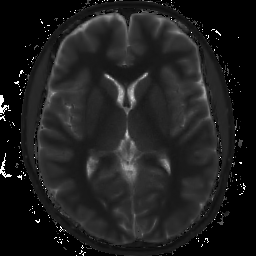

In [38]:
python3 mapping_piecewise.py imgs1 T1 TI maps

bart extract 2 0 3 maps tmp1
bart transpose 2 6 tmp1 tmp2

bart looklocker -t0.1 -D15.3e-3 tmp2 tmp3
bart scale 0.5 tmp3 subspace_brain_T1map

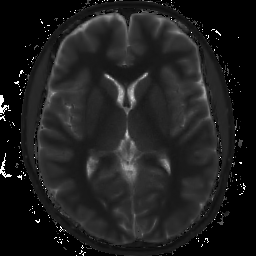

In [39]:
imshow subspace_brain_T1map

python3 save_maps.py subspace_brain_T1map viridis 0 2.0 subspace_brain_T1map.png

In [140]:
rm *.hdr  *.cfl